In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pycbc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter


We load the CSV that contains all glitch times from the first half of the third observing run.

In [2]:
from modules import normality_tests

In [3]:
glitches = pd.read_csv('./glitches/O3a_allifo.csv')
glitches.columns

Index(['GPStime', 'peakFreq', 'snr', 'amplitude', 'centralFreq', 'duration',
       'bandwidth', 'chisq', 'chisqDof', 'confidence', 'id', 'ifo', 'label',
       'imgUrl', 'Q-value'],
      dtype='object')

As you can see it contains a bunch of columns. 
- **GPStime**: The timestamp in GPS format indicating the event time.
- **peakFreq**: The frequency at which the signal has the highest intensity.
- **snr**: Signal-to-noise ratio, indicating the clarity of the signal.
- **amplitude**: The strength or height of the signal wave.
- **centralFreq**: The central frequency of the signal's spectral content.
- **duration**: The time span of the signal event.
- **bandwidth**: The range of frequencies covered by the signal.
- **chisq**: The chi-squared statistic for assessing signal fit quality.
- **chisqDof**: The degrees of freedom used in the chi-squared test.
- **confidence**: The likelihood or certainty of the detection.
- **id**: A unique identifier for the signal event.
- **ifo**: The interferometer associated with the signal detection.
- **label**: Classification or annotation of the event.
- **imgUrl**: Link to an image or visual representation of the signal.
- **Q-value**: Quality factor indicating the sharpness of the signal.

Let's take a look at the **label** column to see all the different glitch classes.

In [4]:
glitches['label'].unique()

array(['Extremely_Loud', 'Scattered_Light', 'Scratchy',
       'Power_Line', 'Koi_Fish', 'Whistle',
       'Low_Frequency_Burst', 'Tomte', 'Repeating_Blips',
       'Fast_Scattering', 'Blip', 'Blip_Low_Frequency',
       'Violin_Mode', 'Helix', 'None_of_the_Above',
       'Low_Frequency_Lines', 'Wandering_Line', 'No_Glitch',
       'Air_Compressor', 'Chirp', 'Light_Modulation',
       'Paired_Doves', '1400Ripples', '1080Lines'], dtype=object)

As a dummy example let's select 'Tomte' glitches from LIGO Livingston (L1)

In [5]:
selected = glitches[(glitches['label'] == 'Tomte') & (glitches['ifo'] == 'L1')]
len(selected), len(selected)

(20804, 20804)

In [6]:
np.round(np.mean(selected['duration'].values), 2)

np.float64(0.66)

You can see that 'Tomte' of 'L1' is a subset of the initial data set. How long are they?

In [7]:
np.unique(selected['duration'])

array([ 0.039,  0.047,  0.055, ..., 13.169, 19.25 , 24.813])

In [8]:
selected.loc[selected["GPStime"] == 1248343512.793]

GPStime  peakFreq     snr     amplitude  centralFreq  duration  \
1041  1.248344e+09    39.789  22.439  1.760000e-22     3799.501     0.875   

        bandwidth  chisq  chisqDof  confidence          id ifo  label  \
1041  7568.411621    0.0       0.0         1.0  HyHGT8uxFq  L1  Tomte   

                                                 imgUrl  Q-value  
1041  https://ldas-jobs.ligo-la.caltech.edu/~gravity...    5.657

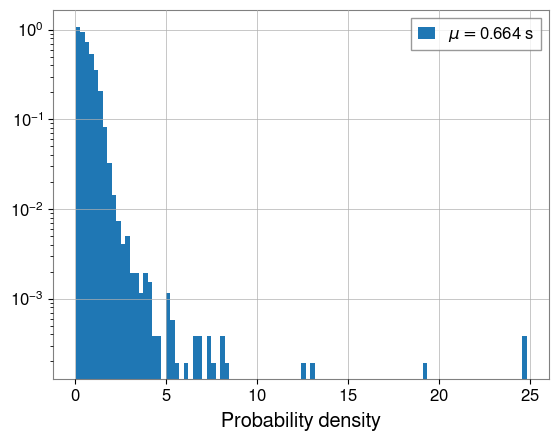

In [9]:
plt.hist(selected['duration'].values, bins=100, density=True,
         label=f'$\mu=$'+str(np.round(np.mean(selected['duration'].values), 3))+' s')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.xlabel('Probability density')
plt.legend()

On average they are 0.664 s long, so we can visualize then in 2s. Let's pick a random example and visualize it.

The `normality_tests` module contains a function `fetch_glitch_data()` that fetches info from the LIGO OSC for L1 at a given gps time for 3 seconds at a sample rate of 4096. This sample is then converted to the pycbc format and whitened.

```python
noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
```

In [10]:
data_df_tomte = normality_tests.fetch_glitch_data(selected, tw=3, begin=0, end=200)
data_df_tomte['shapiro_pvalue'] = data_df_tomte['y'].apply(lambda y: stats.shapiro(y).pvalue) 

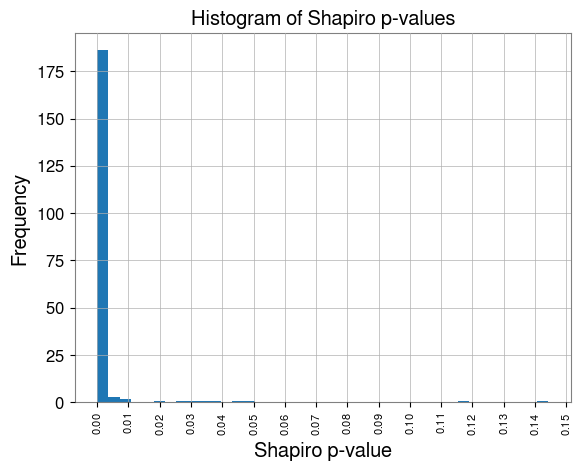

Number of Shapiro p-values above 0.05: 2
Max Shapiro p-value: 0.1442187461790606
Min Shapiro p-value: 1.8640144749932296e-36


In [11]:
normality_tests.shapiro_pvalue_histogram(data_df_tomte)

OK, now we can check its Gaussianity with Saphiro test. We test that the input time series (y) is Gaussian, against the alternative hypothesis that it is non-Gaussian. If the test yields a p-value below $\alpha=0.05$ it means that the input data is non-Gaussian

Using the code above, we lost up the dataset

Changing the sampling rate increases the amount of times we smaple from the data per second. I want to know how the p-values would vary with this change. The gwpy [documentation](https://gwpy.github.io/docs/latest/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.fetch_open_data) states that there can be event data with a 16384 Hz sampling rate which is what I will be using as a reference.

In [12]:
# def p_values_with_sample_rate(begin=0,end=100):
#     data_df_4096 = get_noise_data(selected, tw=3, begin=begin, end=end)
#     data_df_16384 = get_noise_data(selected, tw=3, begin=begin, end=end)

#     data_df_4096['shapiro_pvalue'] = data_df_4096['y'].apply(lambda y: stats.shapiro(y).pvalue)
#     data_df_16384['shapiro_pvalue'] = data_df_16384['y'].apply(lambda y: stats.shapiro(y).pvalue)
    
#     display_shapiro_stats(data_df_4096, 3)
#     display_shapiro_stats(data_df_16384, 3)

#     return data_df_4096, data_df_16384


# data_df_4096, data_df_16384 = p_values_with_sample_rate()



We also check the equality of the numpy arrays to 100% confirm that the distributions are the same. Here we see that the p-values differ by a small margin (in the scale of $10^{-15}$) at to points. At first I thought this was particular to certain values, but on further experimentation, this could most probably be chalked up to floating point precision errors.

In [13]:
# plt.plot(difference)
# plt.xlabel("Index")
# plt.ylabel("Difference in p-values")
# plt.title("Difference in Shapiro p-values (4096 Hz vs. 16384 Hz)")
# plt.show()

Next would be checking the timeframe over which we conduct the test. This is more likely to change the shapiro values as we are increasing the number of points over which we are doing these calculations.

In [14]:
# def p_values_with_time_width():
#     data_df_3 = get_noise_data(selected, tw=3, begin=100, end=150)
#     data_df_4 = get_noise_data(selected, tw=4, begin=100, end=150)
#     data_df_5 = get_noise_data(selected, tw=5, begin=100, end=150)

#     data_df_3['shapiro_pvalue'] = data_df_3['y'].apply(lambda y: stats.shapiro(y).pvalue)
#     data_df_4['shapiro_pvalue'] = data_df_4['y'].apply(lambda y: stats.shapiro(y).pvalue)
#     data_df_5['shapiro_pvalue'] = data_df_5['y'].apply(lambda y: stats.shapiro(y).pvalue)
    
#     display_shapiro_stats(data_df_3, 3)
#     display_shapiro_stats(data_df_4, 4)
#     display_shapiro_stats(data_df_5, 5)

#     return data_df_3, data_df_4, data_df_5


# data_df_3, data_df_4, data_df_5 = p_values_with_time_width()

My hunch was right. The p-values have changed. This could probably be because we are considering more data points as we increase the time window.

Ignoring The outlier, we now focus on values below 0.05

In [15]:
# def view_filtered_histograms_tw(threshold = 0.065):
#     filtered_3 = data_df_3[data_df_3['shapiro_pvalue'] <= 0.06]
#     filtered_4 = data_df_4[data_df_4['shapiro_pvalue'] <= 0.06]
#     filtered_5 = data_df_5[data_df_5['shapiro_pvalue'] <= 0.06]

#     fig, ax = plt.subplots(1, 3, figsize=(21, 6))

#     ax[0].hist(filtered_3['shapiro_pvalue'])
#     ax[0].set_xlabel("Shapiro p-value")
#     ax[0].set_ylabel("Frequency")
#     ax[0].set_title("Shapiro p-values ≤ 0.01 (Time Window = 3s)")


#     ax[1].hist(filtered_4['shapiro_pvalue'])
#     ax[1].set_xlabel("Shapiro p-value")
#     ax[1].set_ylabel("Frequency")
#     ax[1].set_title("Shapiro p-values ≤ 0.01 (Time Window = 4s)")

#     ax[2].hist(filtered_5['shapiro_pvalue'])
#     ax[2].set_xlabel("Shapiro p-value")
#     ax[2].set_ylabel("Frequency")
#     ax[2].set_title("Shapiro p-values ≤ 0.01 (Time Window = 5s)")
#     plt.show()

# view_filtered_histograms_tw()

In [16]:
# fig = plt.figure(figsize=(10, 6))
# fig = plt.figure(dpi=200)

# plt.plot(data_df_3['shapiro_pvalue'], color='blue', alpha=0.3)
# plt.plot(data_df_4['shapiro_pvalue'], color='orange', alpha=0.3)
# plt.plot(data_df_5['shapiro_pvalue'], color='green', alpha=0.3)

# plt.xlabel('Glitch Instance')
# plt.ylabel('p-value')
# plt.title('Comparison of Shapiro p-values with differing time windows')
# plt.legend(['filtered_3', 'filtered_4', 'filtered_5'])
# plt.show()

What I find interesting in these graphs is that the p-values for a time window of 3s fluctuate between 0 to 0.04, for 4s, it fluctuates from 0 to 0.005, and for 5s it is between 0 to 0.05



I now want to investigate the glitch that was classified but was failing this test. I'll use `data_df_tomte` for this

In [17]:
data_df_tomte['ewm_y'] = data_df_tomte['y'].apply(lambda row: pd.Series(row).ewm(0.9).mean().tolist())
# data_df_tomte['ewm_q_transform'] = data_df_tomte['ewm_y'].apply(lambda row: TimeSeries(row, sample_rate=4096).q_transform(qrange=[4,64], frange=[10, 2048], tres=0.002, fres=0.5, whiten=False))
data_df_tomte['ewm_q_transform'] = data_df_tomte['ewm_y'].apply(lambda row: TimeSeries(row, sample_rate=4096).q_transform(qrange=[4,64], frange=[10, 2048], tres=0.002, fres=0.5, whiten=False))

In [18]:
suspicious_glitch = data_df_tomte[data_df_tomte['shapiro_pvalue'] >= 0.05]
suspicious_glitch

GPStime  duration  \
95   1.244890e+09     0.750   
195  1.251456e+09     0.625   

                                                 noise  \
95   [3.510086671449059e-19, 3.5812956386055482e-19...   
195  [3.072020832076944e-19, 3.13807508535111e-19, ...   

                                                     y  \
95   [-121.6816340397279, -52.67657780059757, 43.78...   
195  [-15.067751937818102, -40.79599397132198, -27....   

                                                     t  \
95   [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   
195  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   

                                           q_transform  shapiro_pvalue  \
95   [[FrequencySeries(1.0513928\n                u...        0.115711   
195  [[FrequencySeries(1.0385576\n                u...        0.144219   

     ks_pvalue  ad_statistic                   ad_critical_values  \
95         0.0      0.230804  [0.575, 0.655, 0.786, 0.917, 1.091]   
195        0.0      0.351510  [0.575, 0.655, 0.786, 0.917, 1.091]   

           ad_significance_level  kurtosis      skew  \
95   [15.0, 10.0, 5.0, 2.5, 1.0]  3.130710 -0.021070   
195  [15.0, 10.0, 5.0, 2.5, 1.0]  3.116102 -0.045095   

                                                 ewm_y  \
95   [-121.6816340397279, -74.85677444888945, -4.99...   
195  [-15.067751937818102, -32.5262018891243, -29.7...   

                                       ewm_q_transform  
95   [[FrequencySeries(2.5855672\n                u...  
195  [[FrequencySeries(0.34508297\n                ...

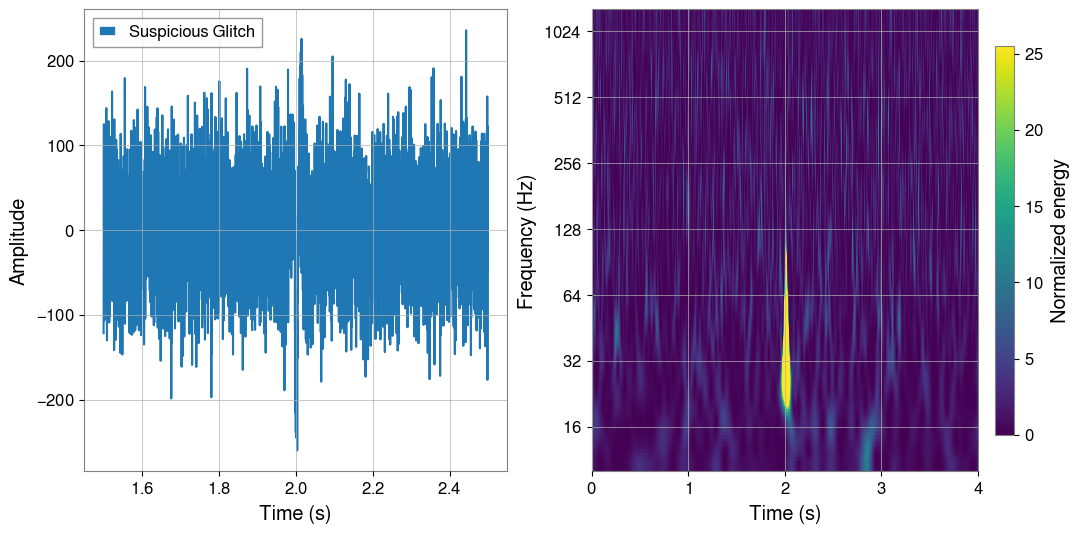

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['y'].iloc[0], label='Suspicious Glitch')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

ax[1].imshow(suspicious_glitch['q_transform'].iloc[0])
ax[1].set_yscale('log', base=2)
ax[1].set_xscale('linear')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].images[0].set_clim(0, 25.5)

fig.colorbar(ax[1].images[0], ax=ax[1], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

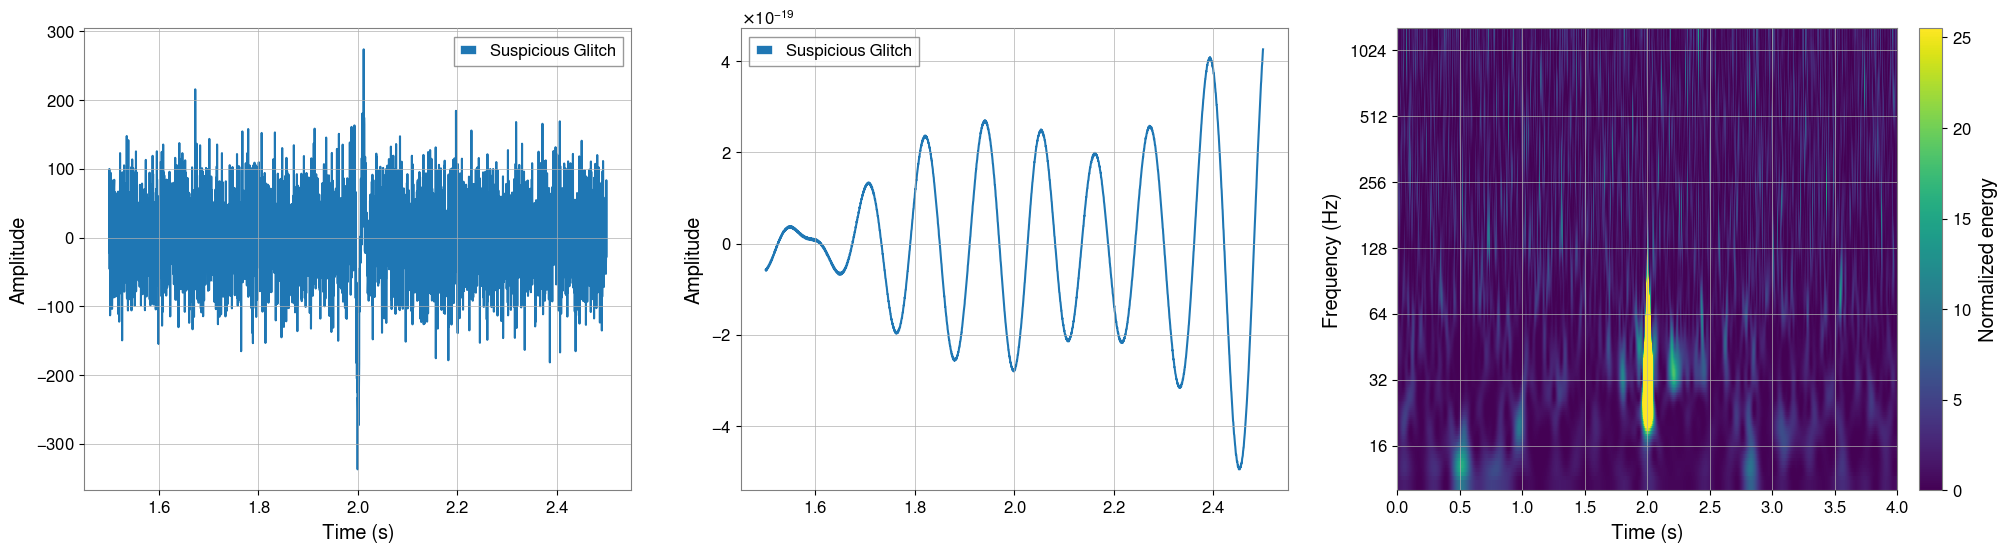

In [20]:
glitch_idx = 9

fig, ax = plt.subplots(1,3, figsize=(24, 6))
ax[0].plot(data_df_tomte['t'].iloc[glitch_idx], data_df_tomte['y'].iloc[glitch_idx], label='Suspicious Glitch')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

ax[1].plot(data_df_tomte['t'].iloc[glitch_idx],data_df_tomte["noise"].iloc[glitch_idx], label='Suspicious Glitch')
# ax[2].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].legend()

ax[2].imshow(data_df_tomte['q_transform'].iloc[glitch_idx])
ax[2].set_yscale('log', base=2)
ax[2].set_xscale('linear')
ax[2].set_ylabel('Frequency (Hz)')
ax[2].set_xlabel('Time (s)')
ax[2].images[0].set_clim(0, 25.5)
fig.colorbar(ax[2].images[0], ax=ax[2], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

The glitch with a p-value above 0.05 does look gaussian in the time-amplitude domain, but its q-transform makes it look similar to the other glitches.

Now, I want to compare this glitch to the other ones to see if its distribution is similar to theirs and by how much. The Kolmogorov-Smirnov test is suitable for this as it provides a statistic and p-value to work with.

In [21]:
data_df_tomte.columns

Index(['GPStime', 'duration', 'noise', 'y', 't', 'q_transform',
       'shapiro_pvalue', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'ewm_y',
       'ewm_q_transform'],
      dtype='object')

In [22]:
sus_y_values = suspicious_glitch.iloc[0]['y']

ks_stats = list(data_df_tomte['y'].apply(lambda row: tuple(stats.ks_2samp(row,sus_y_values))))

In [23]:
ks_stats = pd.DataFrame(ks_stats, columns=['suspicious_KS_statistic', 'suspicious_KS_p_value'])
data_df_tomte = data_df_tomte.join(ks_stats[['suspicious_KS_statistic', 'suspicious_KS_p_value']])

Now that I have the KS statistic and p-values, I can now see how the suspicious glitch here fares with the others

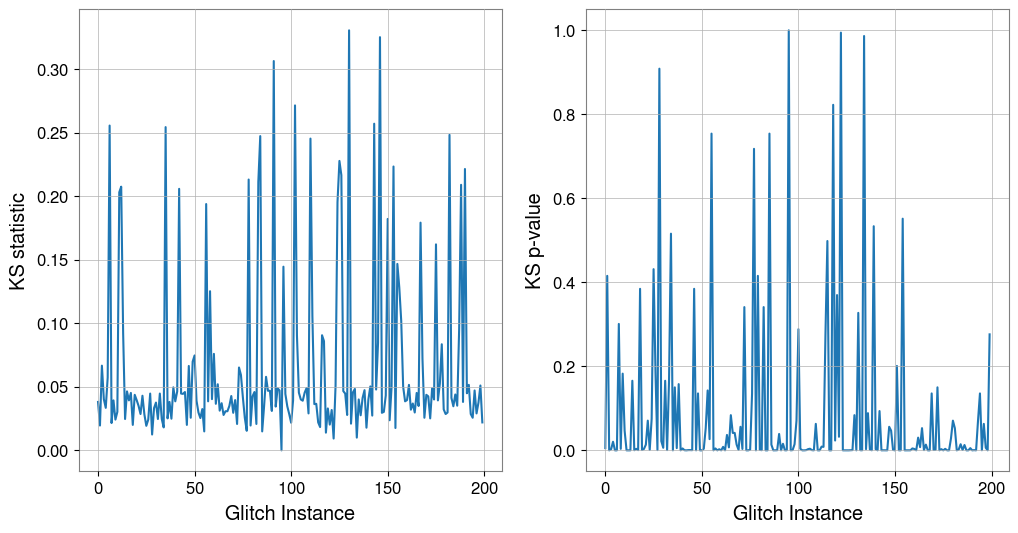

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

# plt.title("Kolmogorov Smirnov Statistic and P-values of data compared to outlier glitch")
ax[0].plot(data_df_tomte['suspicious_KS_statistic'])
ax[0].set_ylabel("KS statistic")
ax[0].set_xlabel("Glitch Instance")

ax[1].plot(data_df_tomte['suspicious_KS_p_value'])
ax[1].set_ylabel('KS p-value')
ax[1].set_xlabel('Glitch Instance')

plt.show()

Due to how much this statistic varies with each of the glitches in our sample set, it will probably not be of much use to us in determining whether the glitch that we are studying is similar to the other ones are not. Additionally the KS test doesn't take into consideration the temporal nature of our data, which is problematic.

An idea I wanted to try for this was [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping). This algorithm can compare the simlarities between two temporal sequences, taking into account their speed (warping). However this assumes there to be a phase shift between the timeseries and does not account for changes in amplitudes. 

In our case, we would go for something akin to lock-step distance. The main issue however is the whitening that has been done to our signal.

Since our signal is being introduced to white noise, it is effectively a vaguely glitch-like white noise signal that we are dealing with. I could try applying a weighted average that would help capture the general trend of the glitch as it moves along, along with either one of the two methods.

We first do the lock-step calculations with the glitches directly

In [25]:
def lock_step(sus, row):
    return np.sqrt(((sus-row)**2).sum())

data_df_tomte['lock_step_distance'] = data_df_tomte['y'].apply(lambda row: lock_step(np.array(row) , np.array(sus_y_values)))

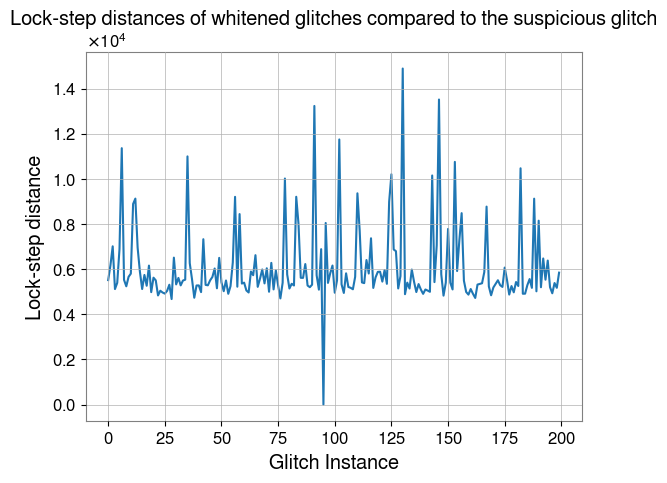

In [26]:
fig = plt.figure(dpi=100)
plt.plot(data_df_tomte['lock_step_distance'])

plt.xlabel('Glitch Instance')
plt.ylabel('Lock-step distance')
plt.title('Lock-step distances of whitened glitches compared to the suspicious glitch')
plt.show()

We notice that a lot of the lock-step distance values hover around the 5500 t0 6100 range. However there are some points where the variation is extremely high. I want to compare this with th KS statistic to see the parallels.

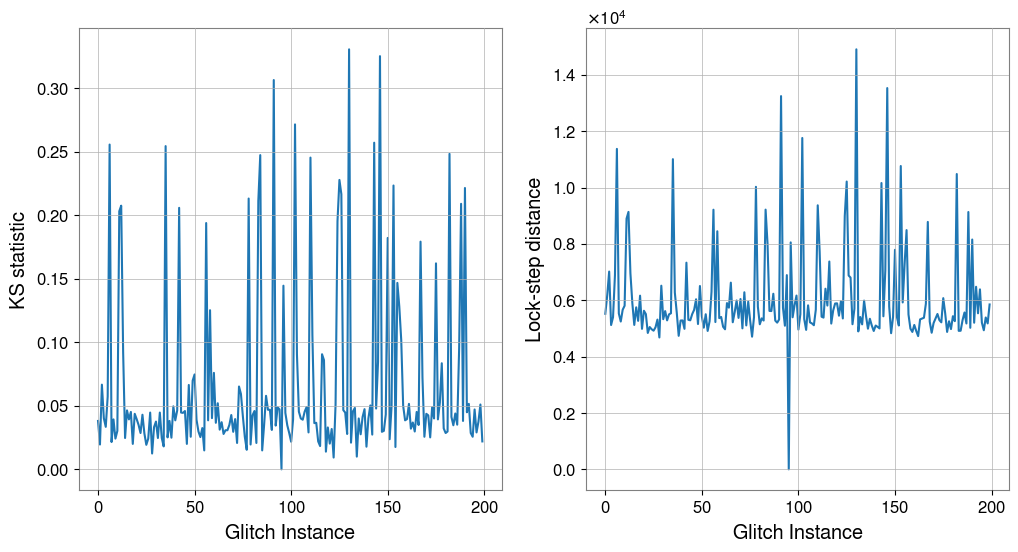

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

ax[0].plot(data_df_tomte['suspicious_KS_statistic'])
ax[0].set_ylabel("KS statistic")
ax[0].set_xlabel("Glitch Instance")

ax[1].plot(data_df_tomte['lock_step_distance'])
ax[1].set_ylabel('Lock-step distance')
ax[1].set_xlabel('Glitch Instance')

plt.show()

We notice that both these plots have spikes at similar points, having a zero value at point 28 (the suspicious glitch).

I'll now take the weighted average and do the same. First i want to see what our suspicious glitch looks when taken as a weighted average.

In [28]:
data_df_tomte.iloc[0]

GPStime                                                       1243679045.582
duration                                                                1.25
noise                      [-1.0854155103346084e-19, -1.3654645578018337e...
y                          [21.617924606611343, 46.53666106903427, 8.5402...
t                          [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...
q_transform                [[FrequencySeries(0.42193764\n                ...
shapiro_pvalue                                                           0.0
ks_pvalue                                                                0.0
ad_statistic                                                        2.311046
ad_critical_values                       [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                            [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                            4.383921
skew                                                               -0.248636

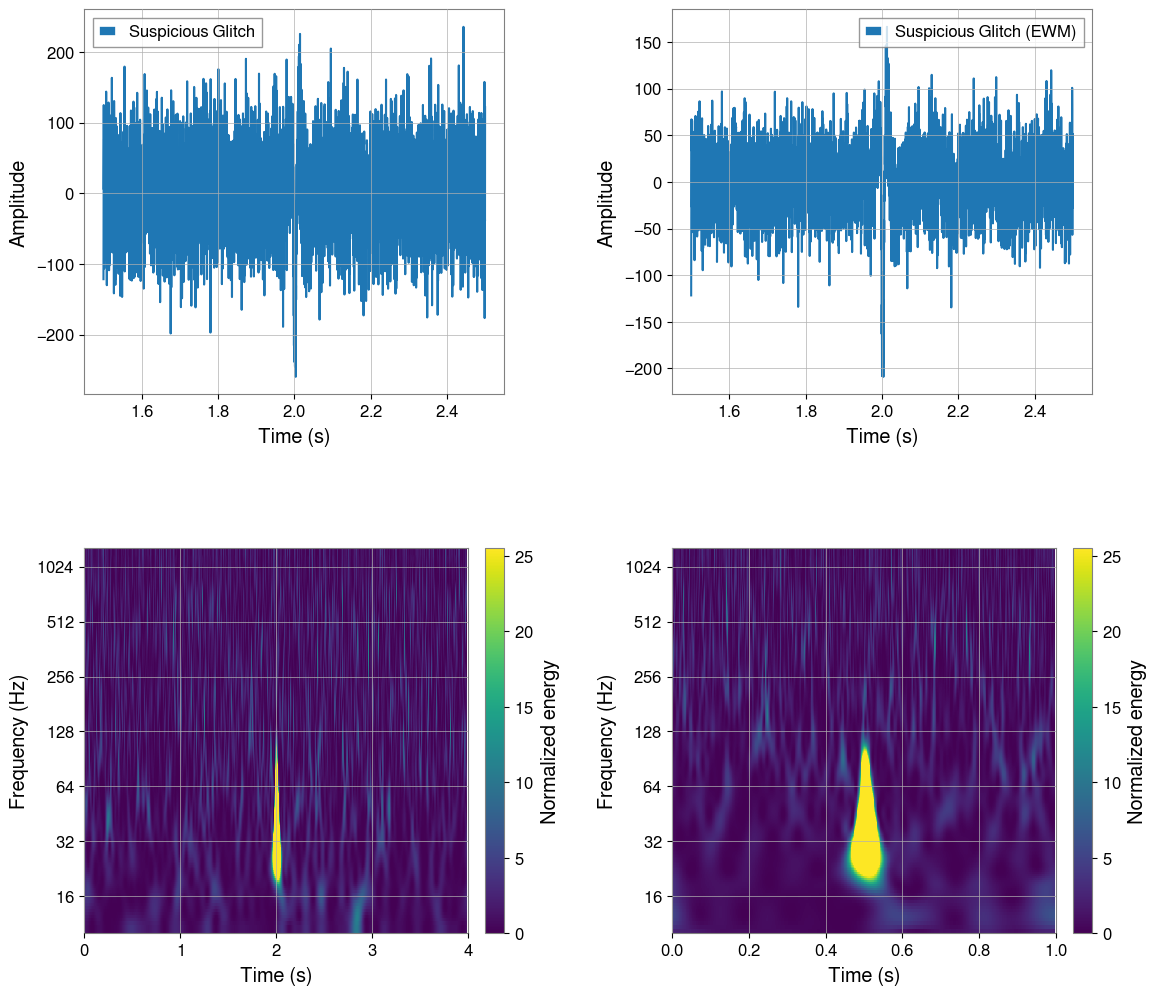

In [29]:
fig, ax = plt.subplots(2,2, figsize=(13, 12))
ax[0][0].plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['y'].iloc[0], label='Suspicious Glitch')
ax[0][0].set_xlabel("Time (s)")
ax[0][0].set_ylabel("Amplitude")
ax[0][0].legend()

ax[0][1].plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['ewm_y'].iloc[0], label='Suspicious Glitch (EWM)')
ax[0][1].set_xlabel("Time (s)")
ax[0][1].set_ylabel("Amplitude")
ax[0][1].legend()
# ax[1].images[0].set_clim(0, 25.5)

ax[1][0].imshow(suspicious_glitch['q_transform'].iloc[0])
ax[1][0].set_yscale('log', base=2)
ax[1][0].set_xscale('linear')
ax[1][0].set_ylabel('Frequency (Hz)')
ax[1][0].set_xlabel('Time (s)')
ax[1][0].images[0].set_clim(0, 25.5)
fig.colorbar(ax[1][0].images[0], ax=ax[1][0], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

ax[1][1].imshow(suspicious_glitch['ewm_q_transform'].iloc[0])
ax[1][1].set_yscale('log', base=2)
ax[1][1].set_xscale('linear')
ax[1][1].set_ylabel('Frequency (Hz)')
ax[1][1].set_xlabel('Time (s)')
ax[1][1].images[0].set_clim(0, 25.5)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

fig.colorbar(ax[1][1].images[0], ax=ax[1][1], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

# Testing EWA on white noise

0.19972627751527766


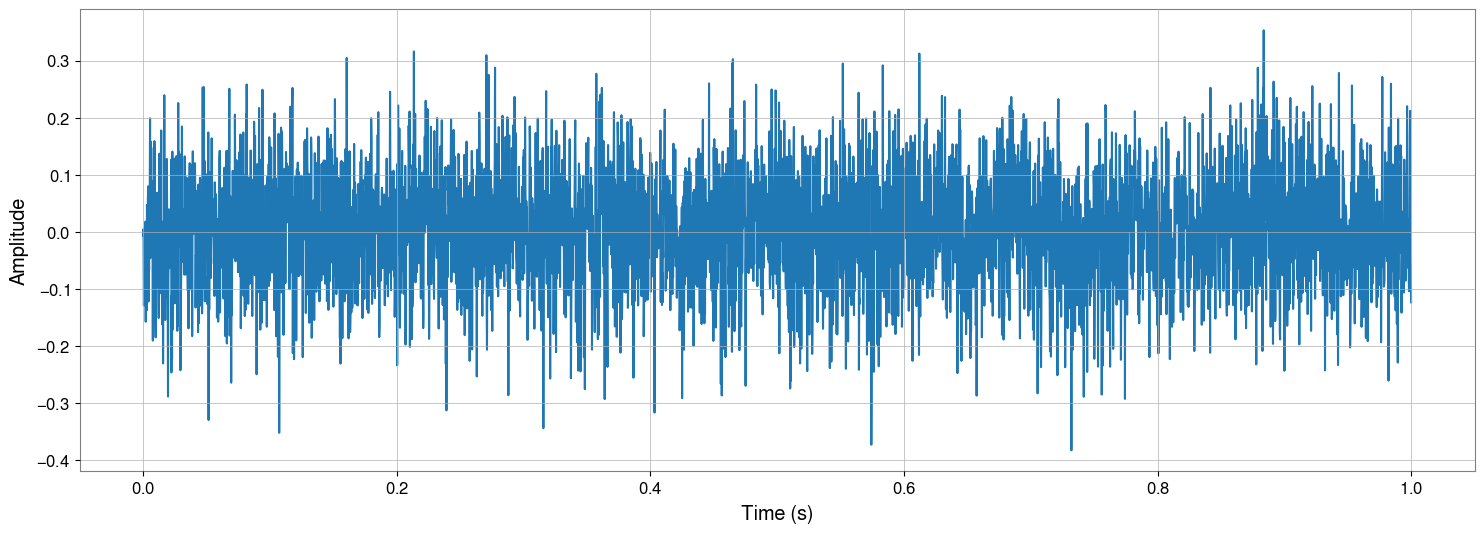

In [30]:
# creating noise
example_noise = TimeSeries(np.random.normal(scale=.1, size=4096), sample_rate=4096)
print(stats.shapiro(example_noise.value).pvalue)
fig = plt.figure(figsize=(18,6))
plt.plot(example_noise)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [31]:
ewm_example_1 = pd.Series(example_noise.value).ewm(0).mean()
ewm_example_2 = pd.Series(example_noise.value).ewm(0.5).mean()
ewm_example_3 = pd.Series(example_noise.value).ewm(0.8).mean()
ewm_example_4 = pd.Series(example_noise.value).ewm(0.9).mean()
ewm_example_5 = pd.Series(example_noise.value).ewm(0.98).mean()
ewm_example_6 = pd.Series(example_noise.value).ewm(0.9999).mean()

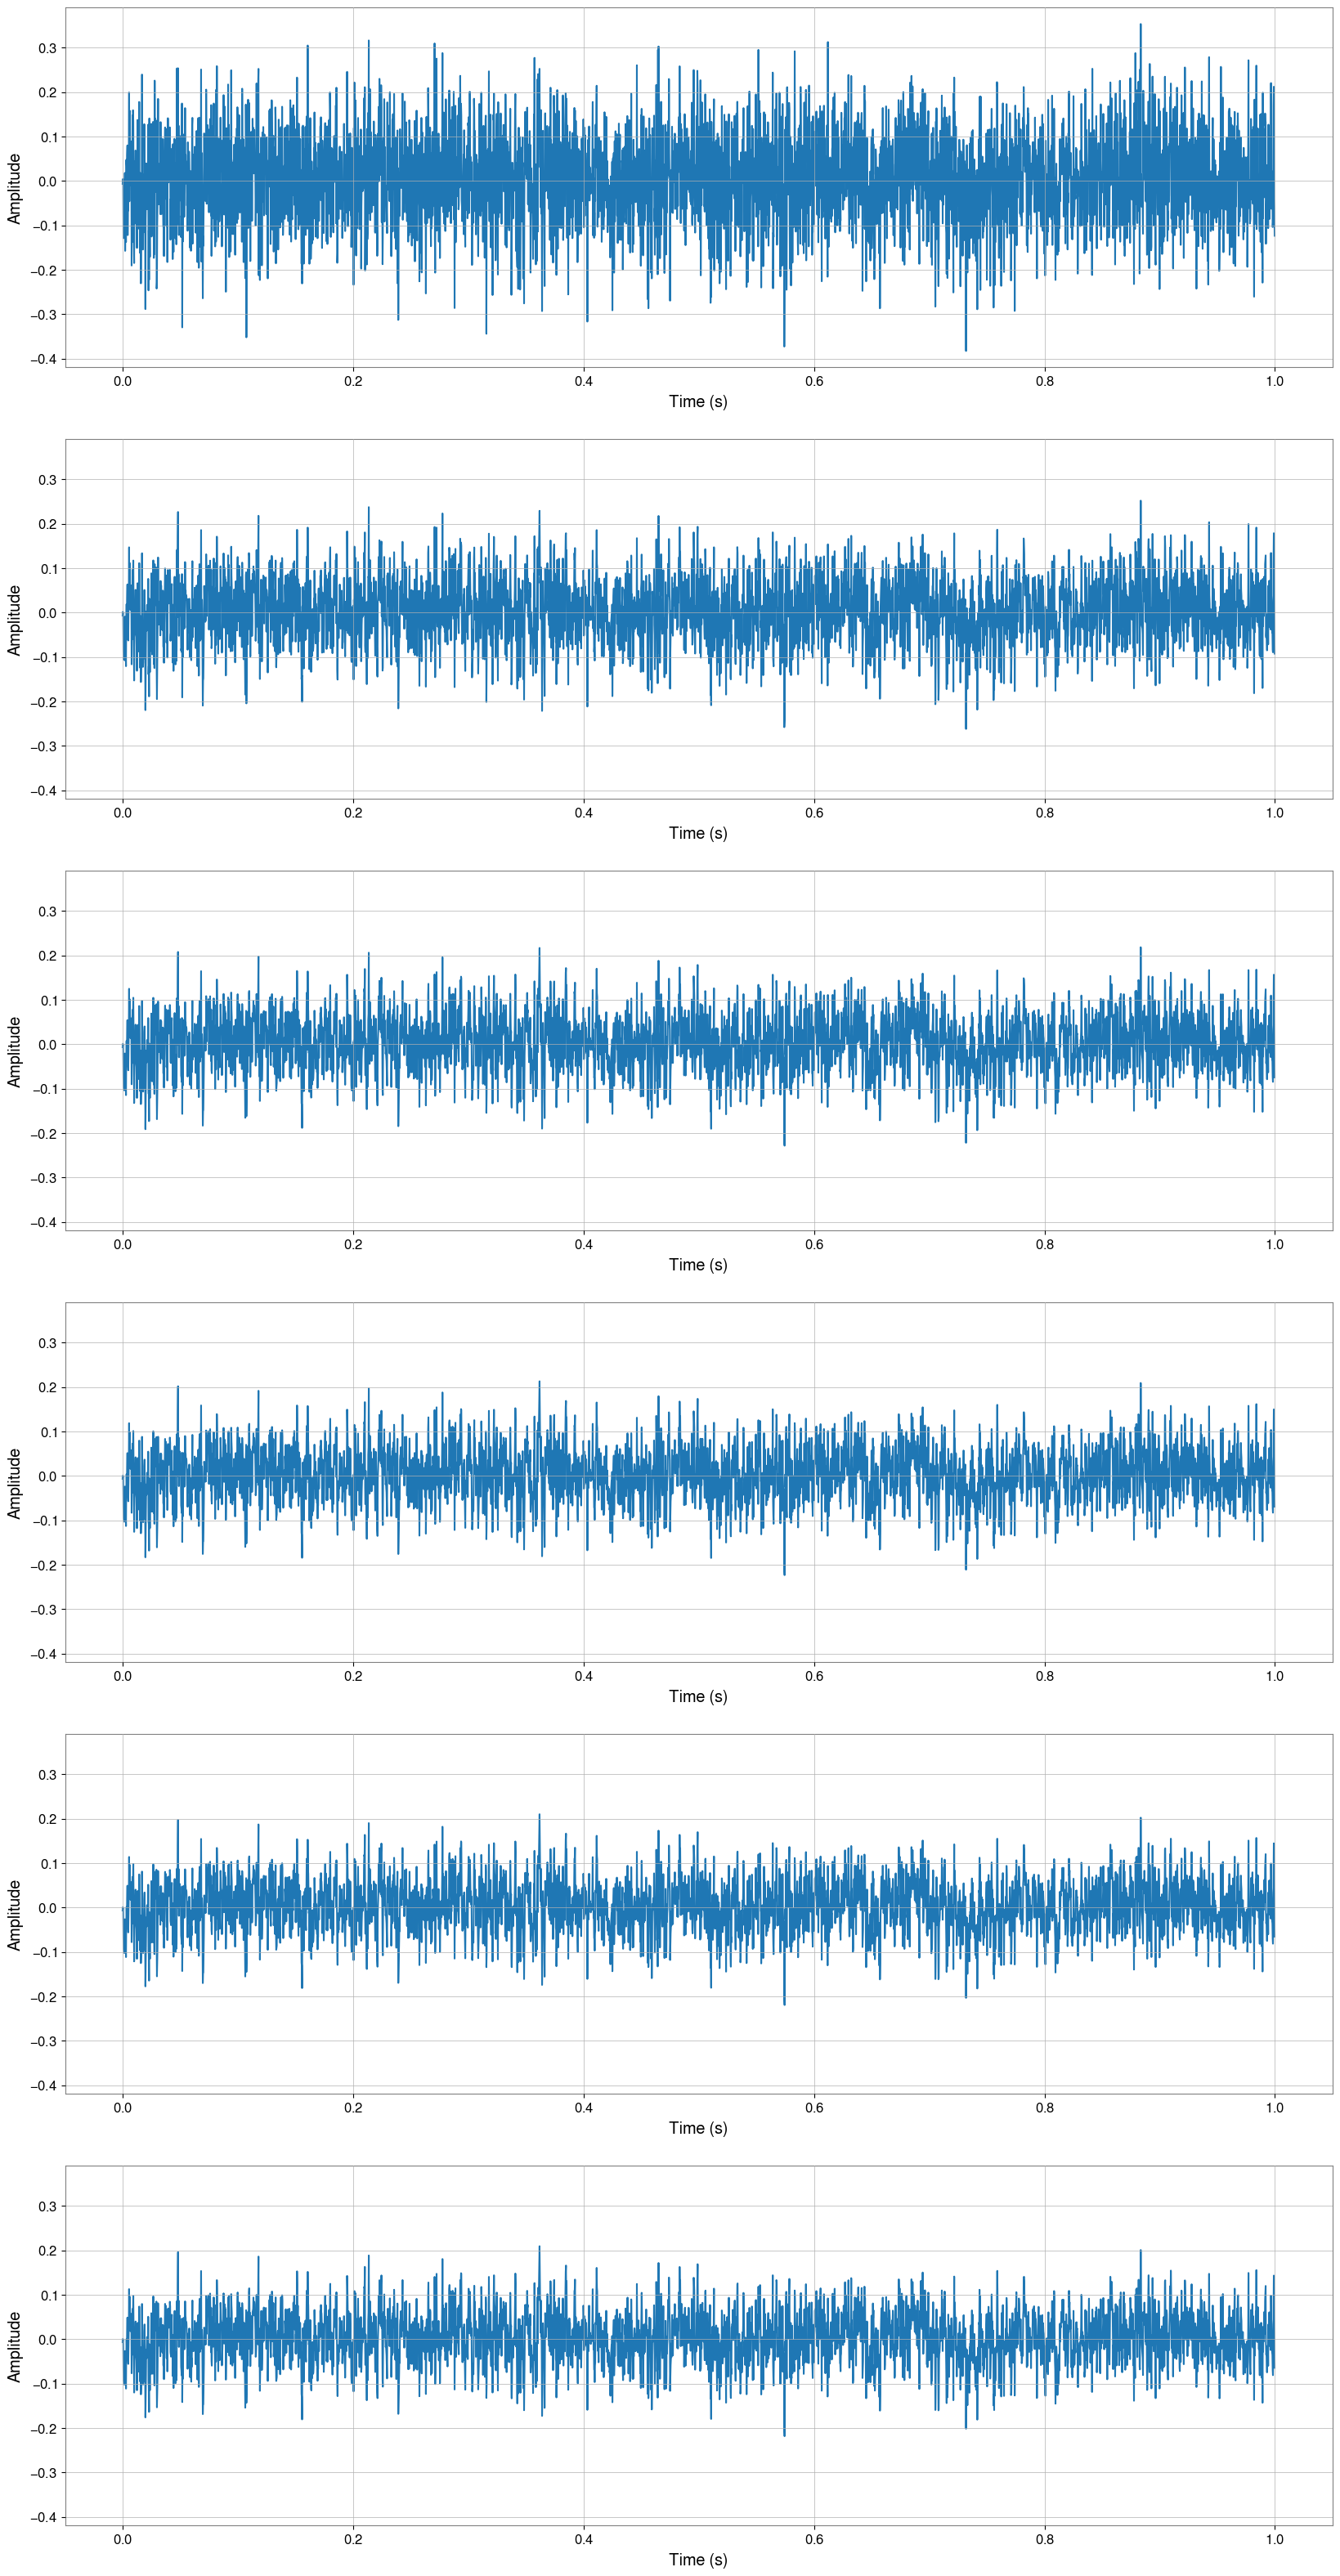

In [32]:
fig, ax = plt.subplots(6, 1, figsize=(20,40), sharey=True, dpi=100)

ax[0].plot(example_noise.times, ewm_example_1)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")

ax[1].plot(example_noise.times, ewm_example_2)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")

ax[2].plot(example_noise.times, ewm_example_3)
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Amplitude")

ax[3].plot(example_noise.times, ewm_example_4)
ax[3].set_xlabel("Time (s)")
ax[3].set_ylabel("Amplitude")

ax[4].plot(example_noise.times, ewm_example_5)
ax[4].set_xlabel("Time (s)")
ax[4].set_ylabel("Amplitude")

ax[5].plot(example_noise.times, ewm_example_6)
ax[5].set_xlabel("Time (s)")
ax[5].set_ylabel("Amplitude")

plt.show()

What's happening here is that the effective values following the first sample are dampened with the following formula

$$\text{ewm}_{t} = \alpha \text{ val}_{t} + (1 - \alpha) \text{ewm}_{t-1}$$

where $\text{ewm}_{t}$ is the exponentially weighted mean at $t$, and $\alpha$ is a user defined value between $(0,1)$

So at every point, we take into account previous points in our timeseries. Hence, the white noise is not necessarily going to remain as white noise.

Also, from a visual standpoint, the glitch seems to be converging to the mean, which in this case is zero since the white noise here is zero centered.

# Using the Shapiro Wilks test on smaller parts of a glitch

We now take our suspicious glitch and perform the Shapiro-Wilks test on sections of it.

Shapiro p-values
Sample p-value:0.11571115313674346
0.5227944649692046
0.028782483160401575
0.4251833296481836
0.8014372475003053
0.18903133137299893
0.7462869190513418
0.4203514630991345
0.027718216224727588
0.10847107952287854
0.9563924529647705
0.5629424492631786
0.7758503920320491
0.785185721141691
0.6612110020758355
0.9749194827223712
0.16724955214801468


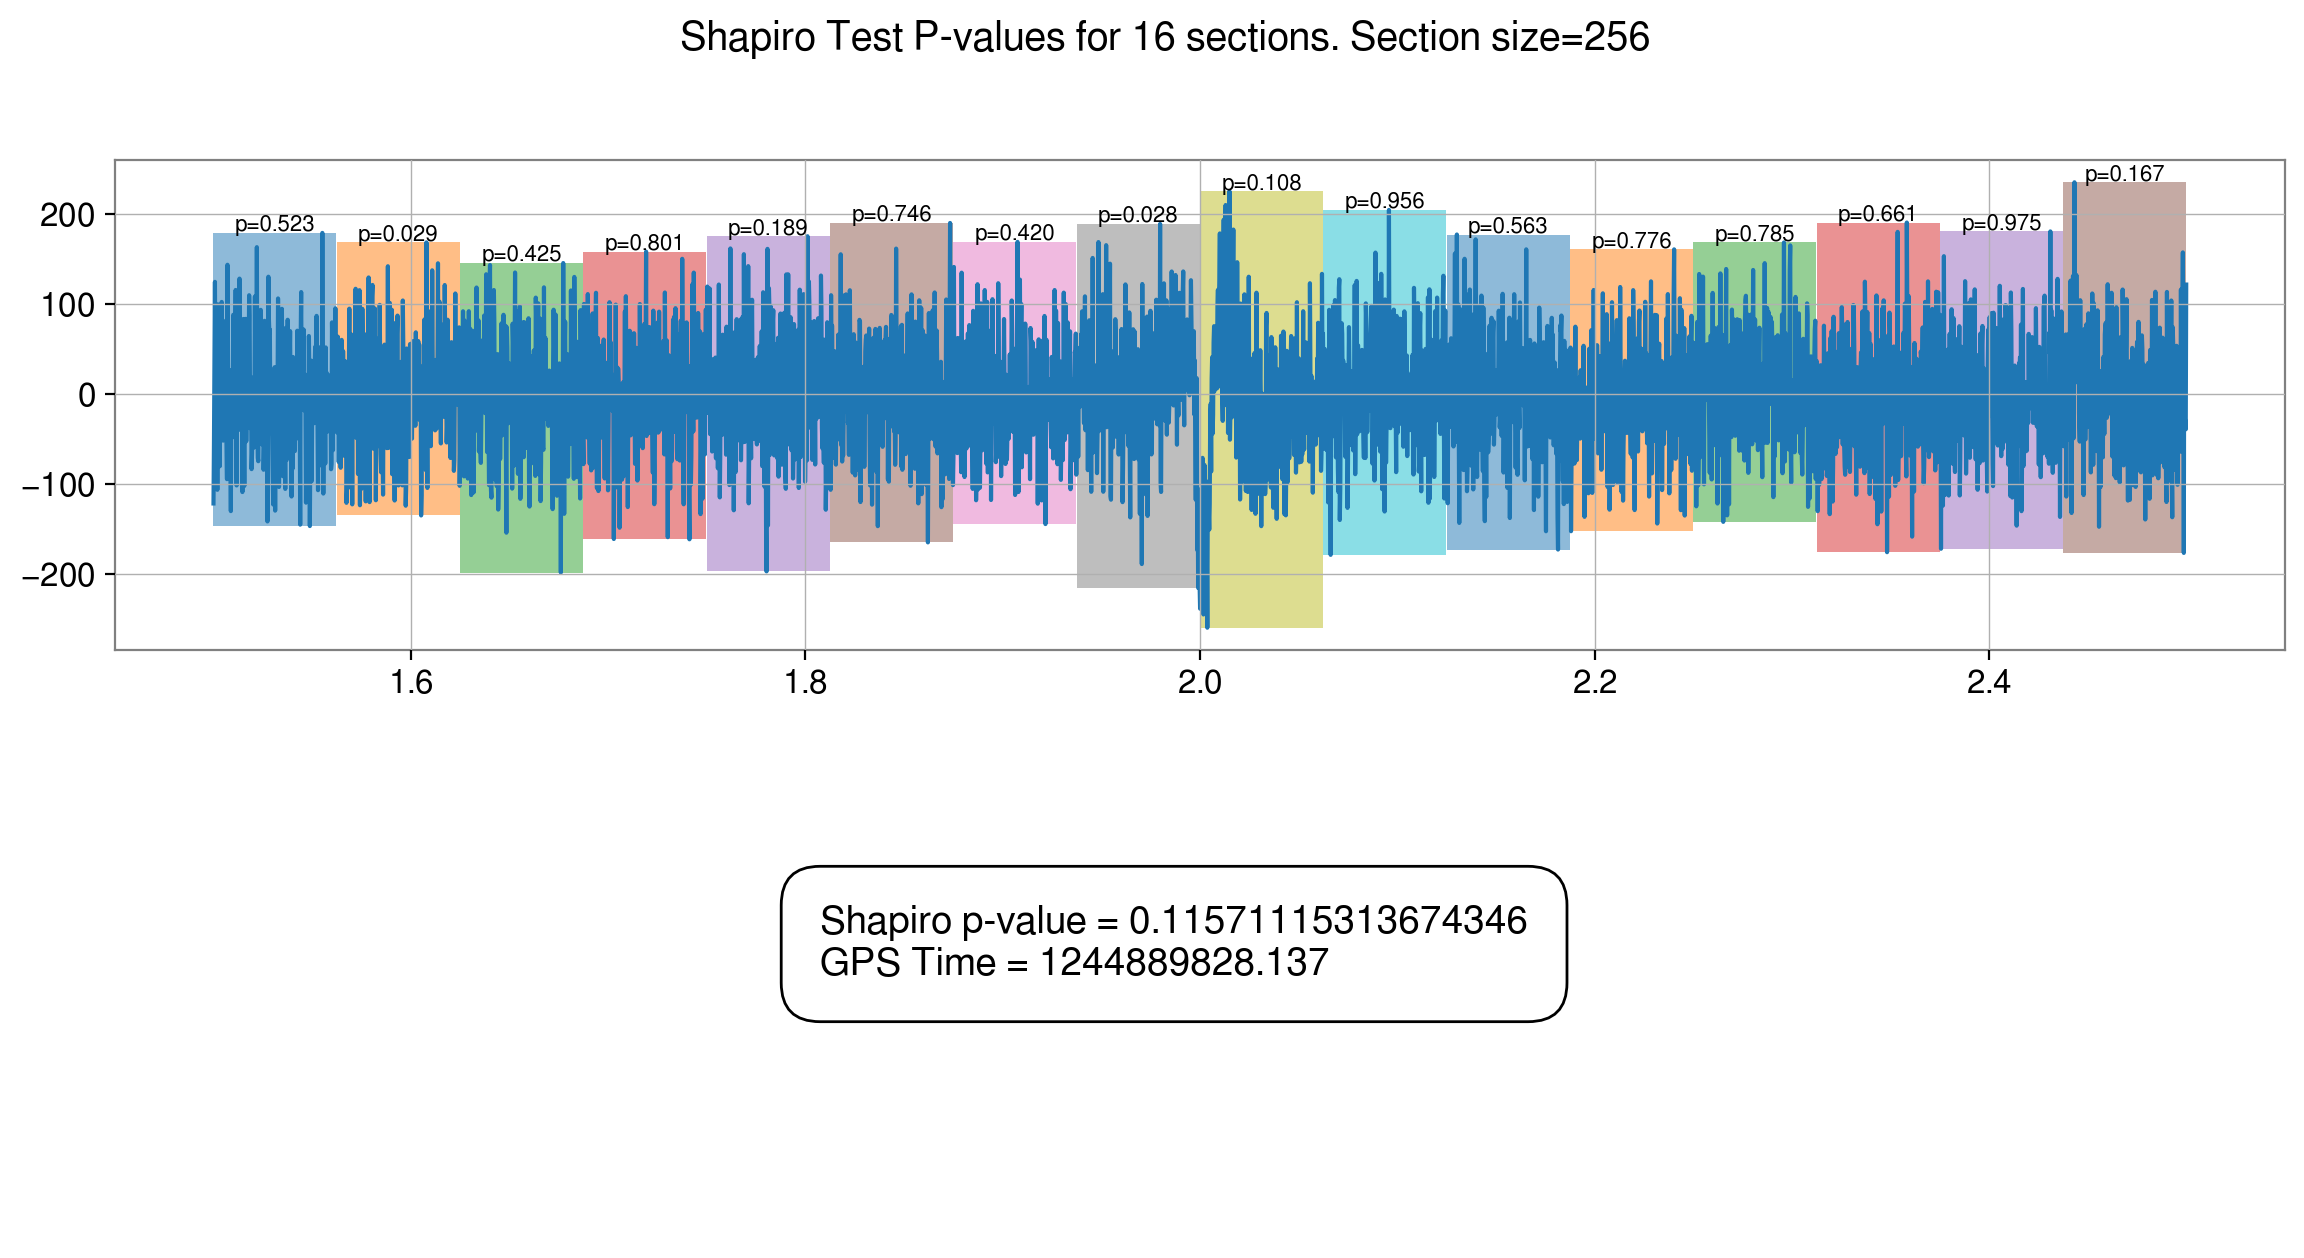

In [33]:
_ = normality_tests.display_section_shapiro(suspicious_glitch.iloc[0], 16)

Shapiro p-values
Sample p-value:0.11571115313674346
0.13164851031366726
0.31351598921725227
0.00643641558159392
0.5194430420667034


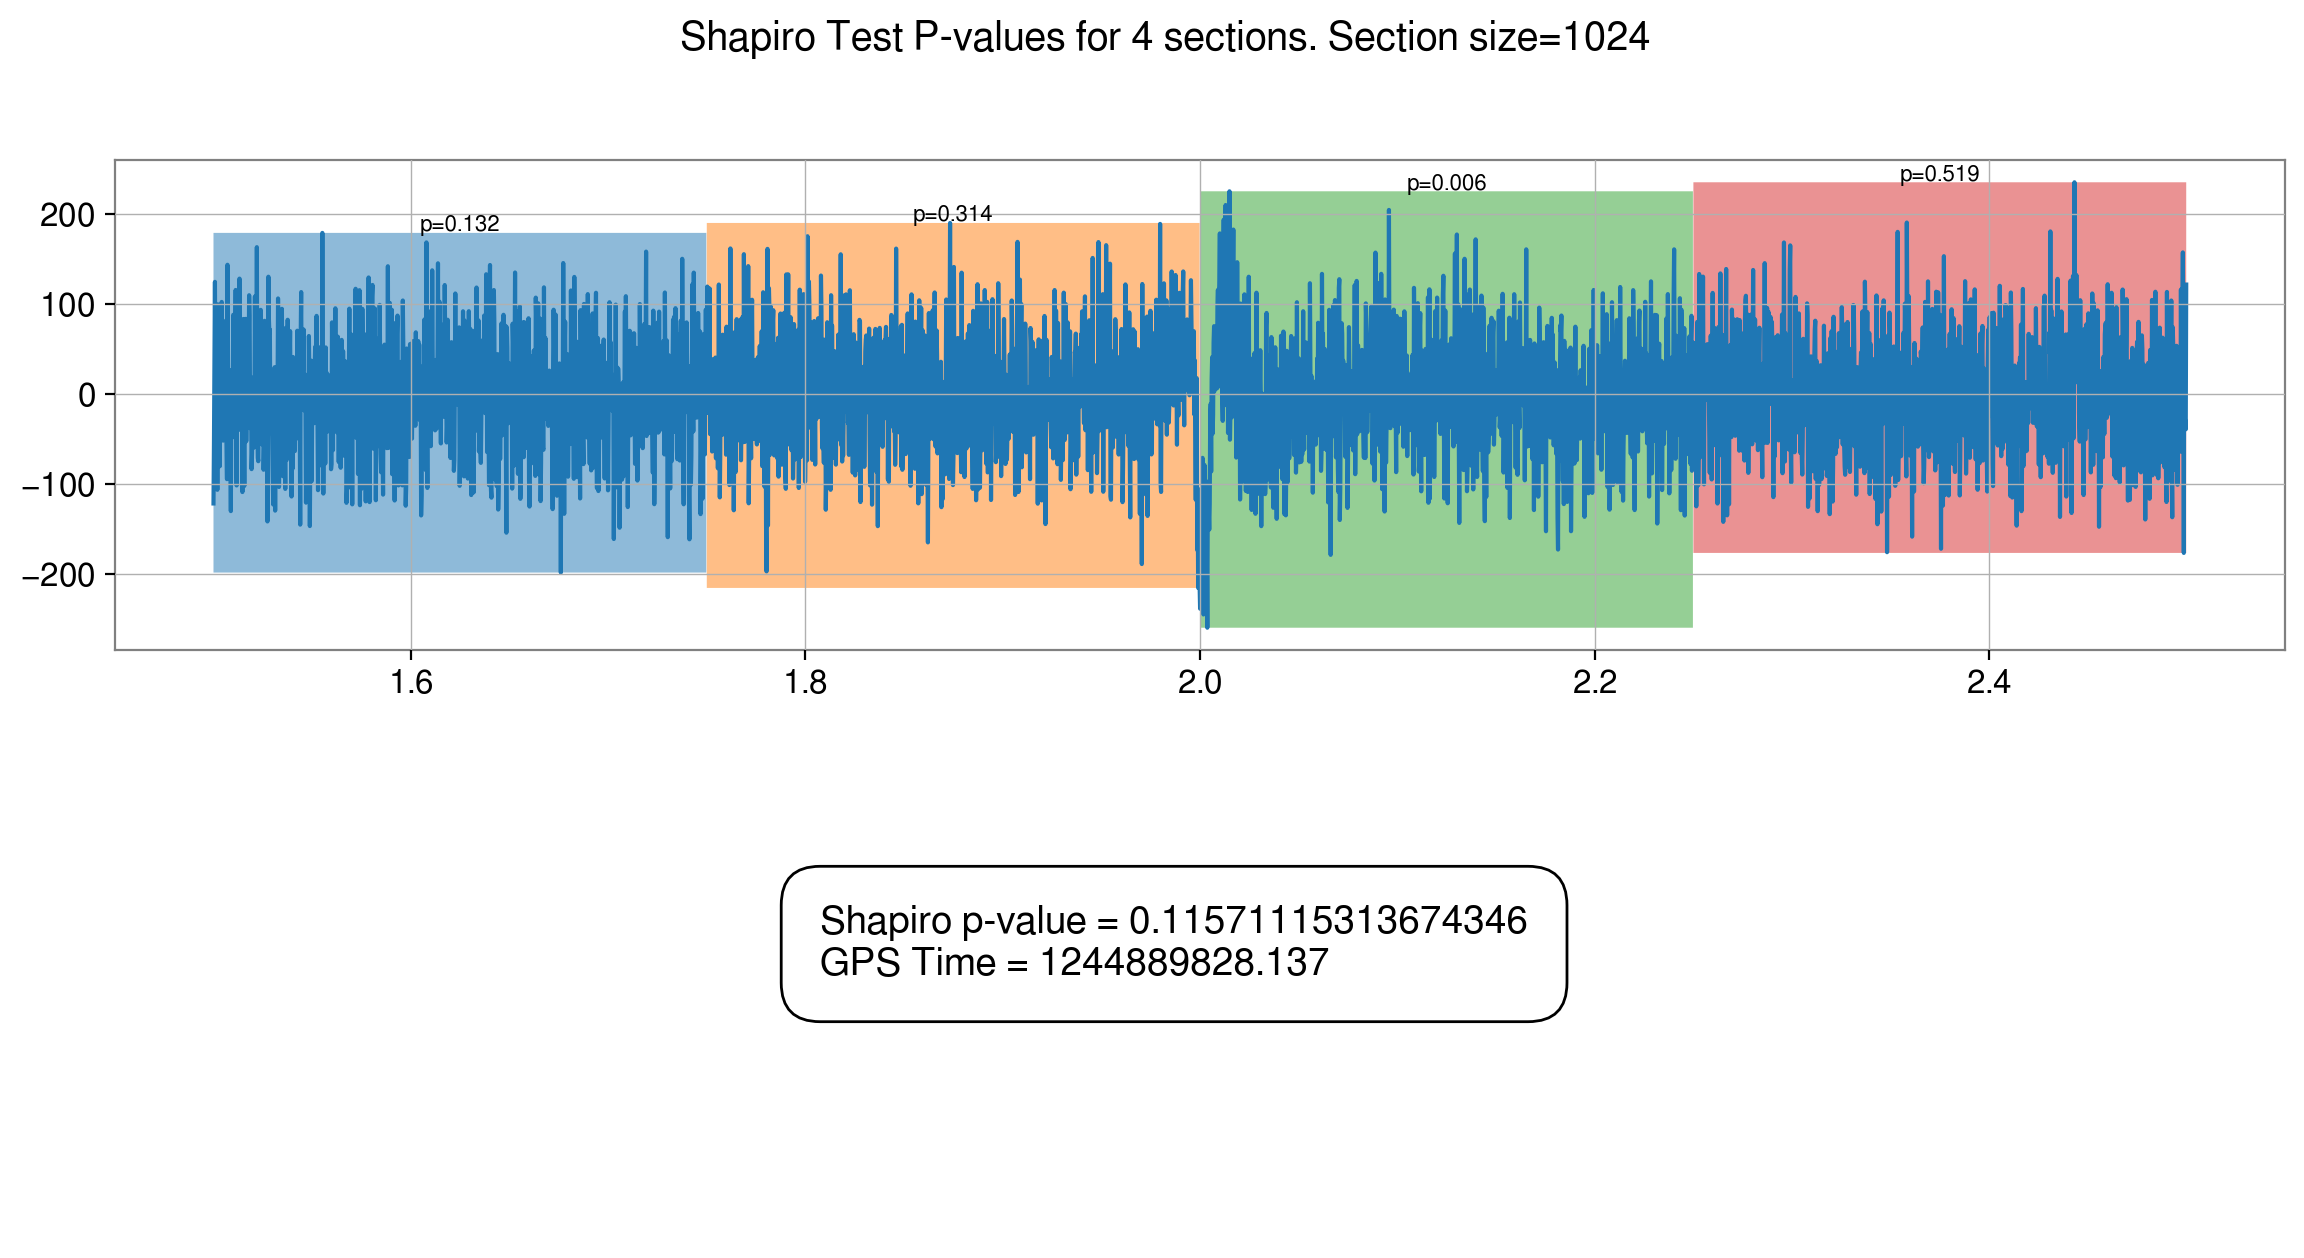

In [34]:
_ = normality_tests.display_section_shapiro(suspicious_glitch.iloc[0], 4)

Shapiro p-values
Sample p-value:0.11571115313674346
0.5135240863532202
0.0060873475528404365
0.6076611541587886


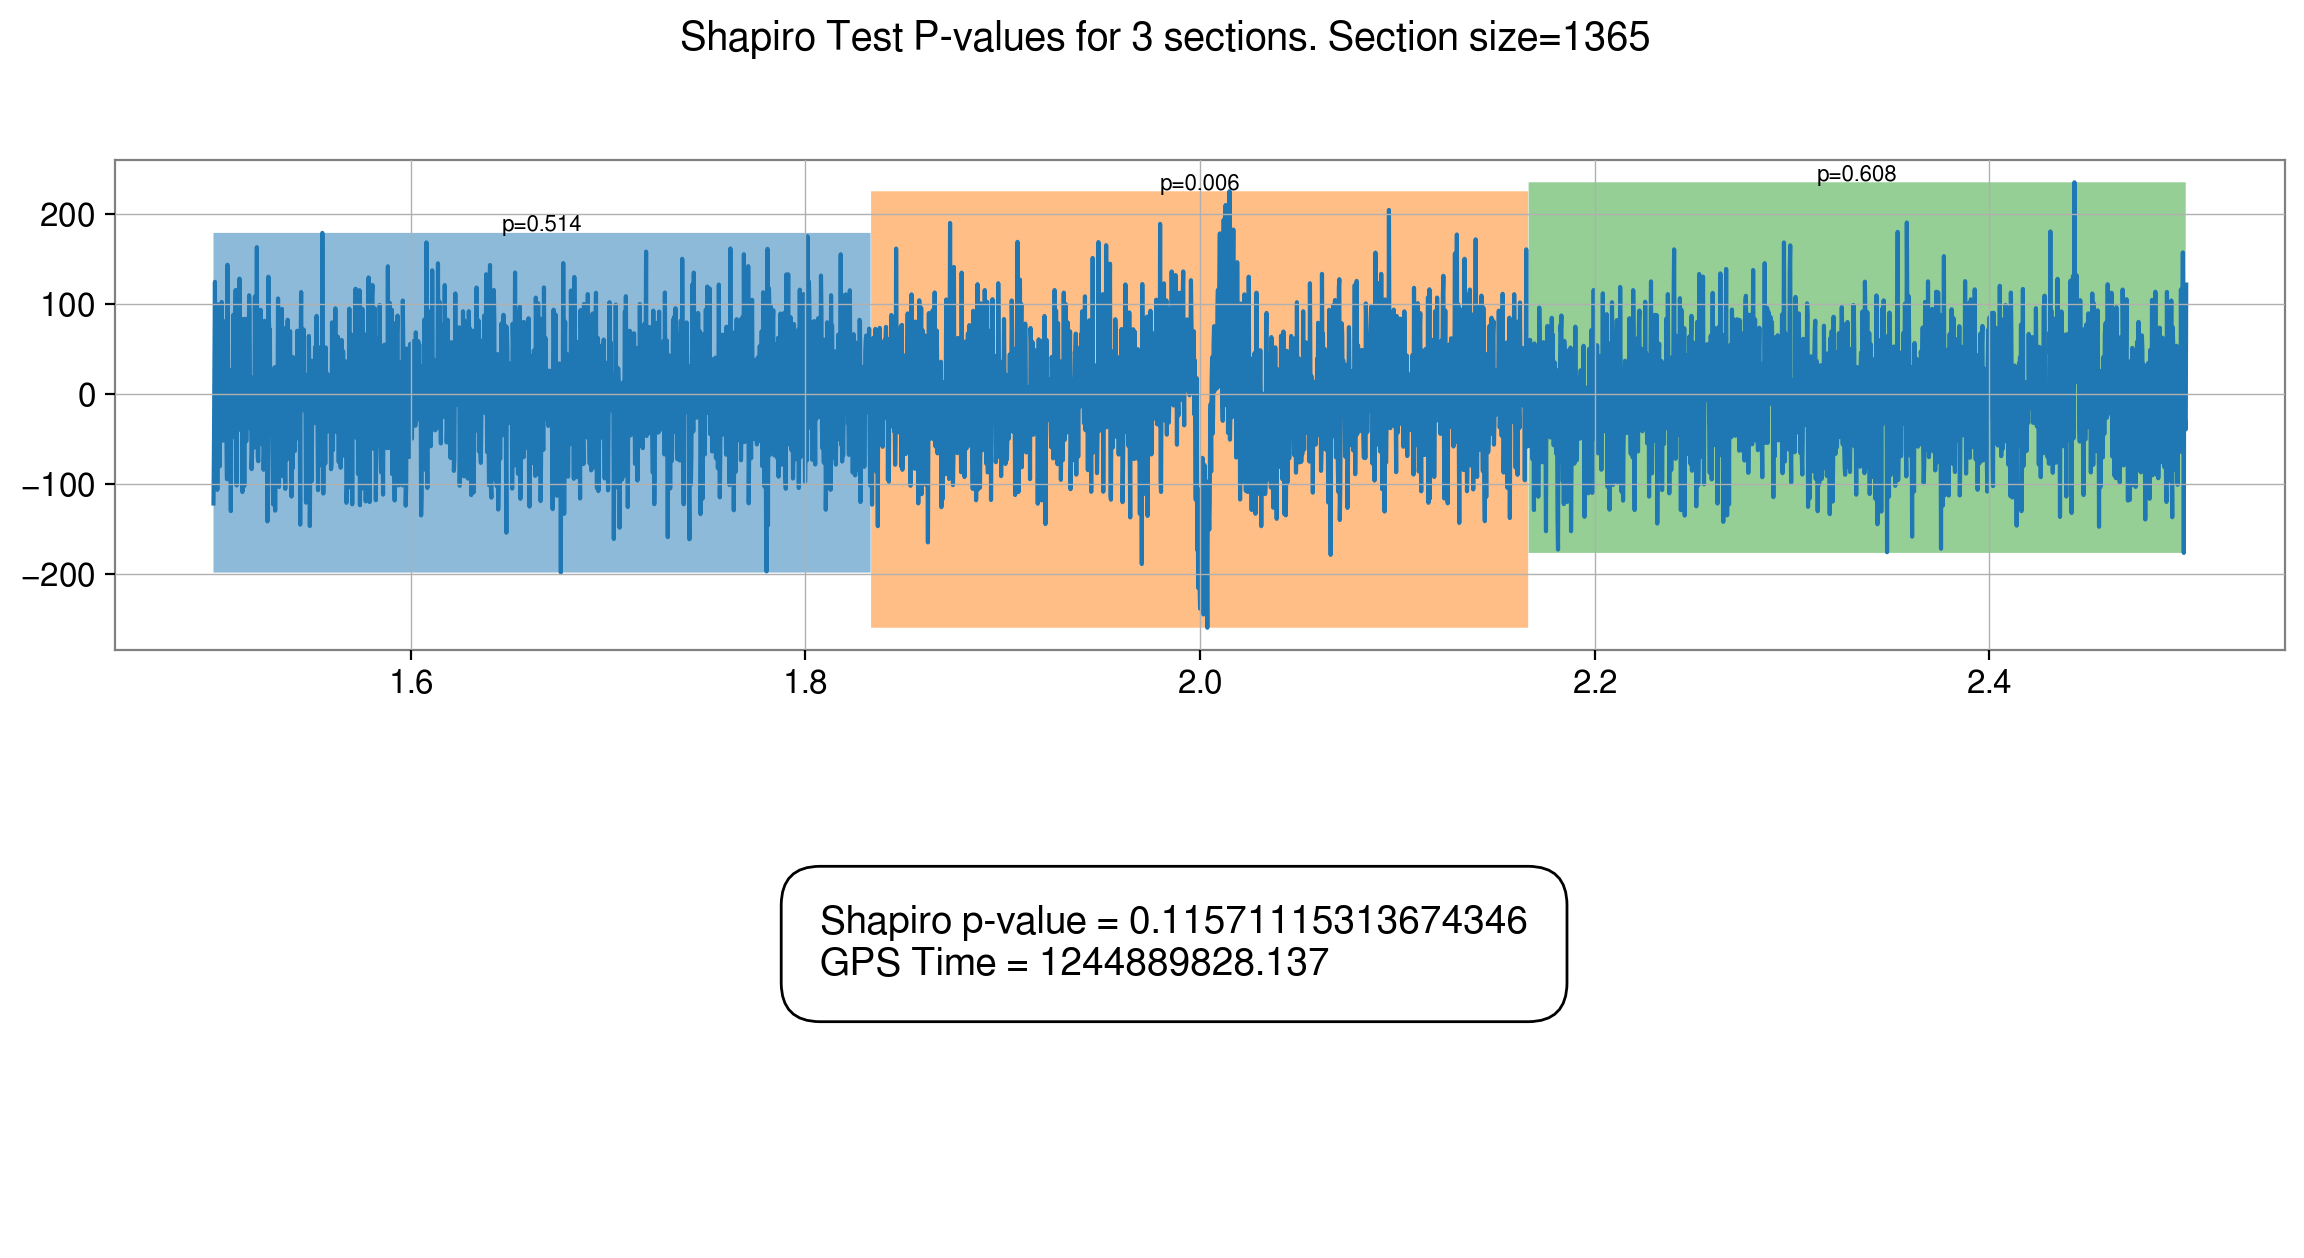

In [35]:
_ = normality_tests.display_section_shapiro(suspicious_glitch.iloc[0], 3)

Shapiro p-values
Sample p-value:0.11571115313674346
0.1047897015017833
0.5946094054929649
0.48867598672583856
0.8163424237138482
0.004045402559165568
0.649123152104687
0.2152672599198382
0.6939363283349465
0.3503311770770411


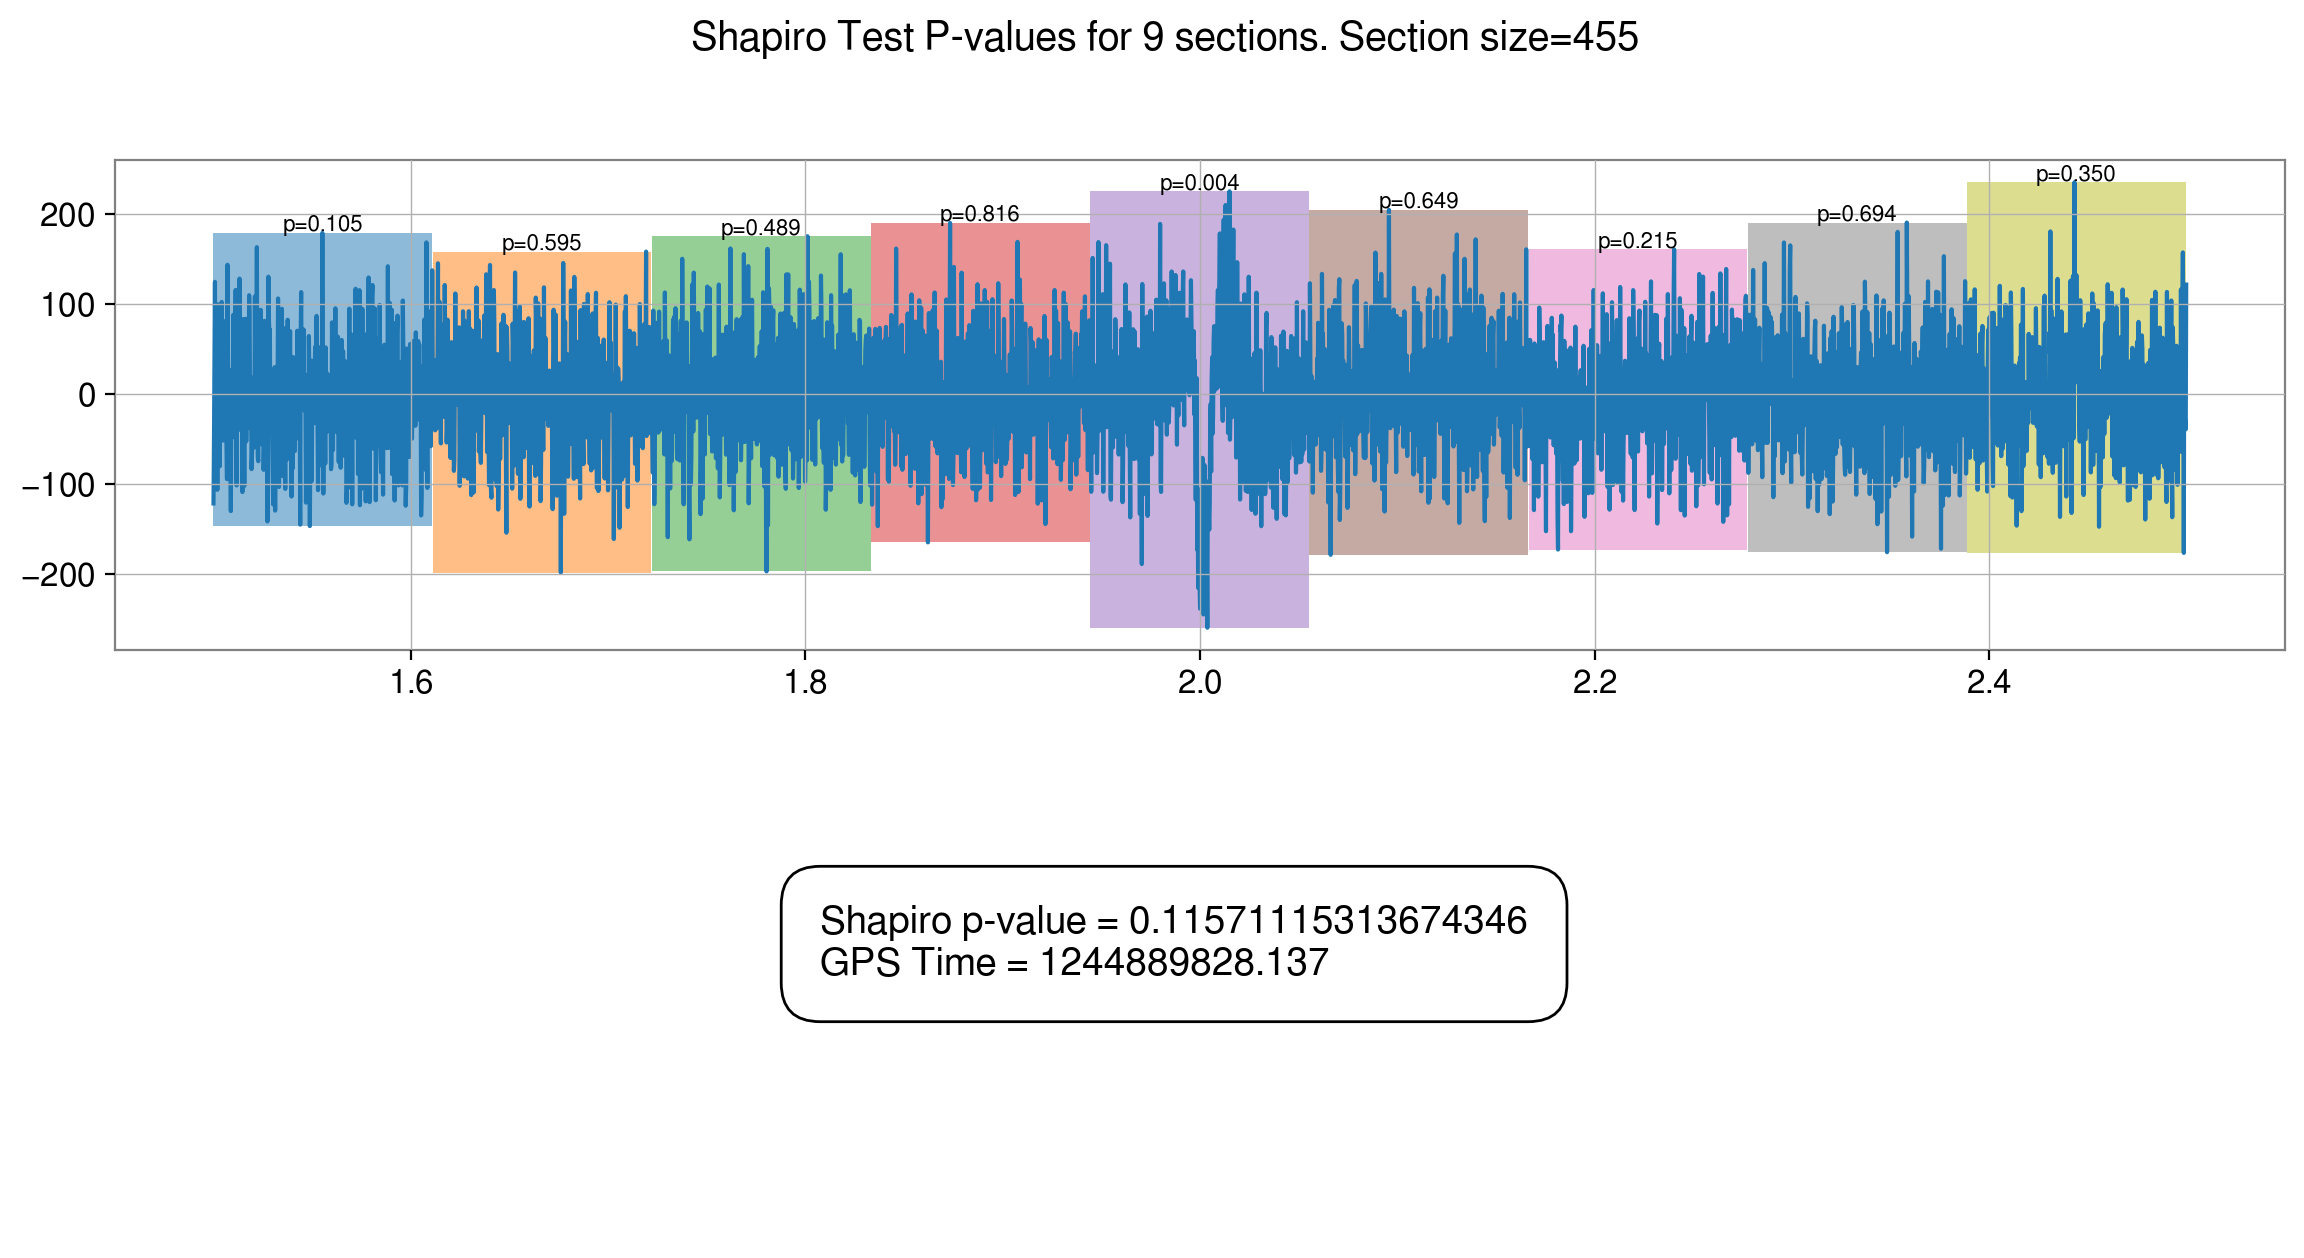

In [36]:
_ = normality_tests.display_section_shapiro(suspicious_glitch.iloc[0], 9)


From the above plots, we see that the Shapiro-Wilk test works well for sections of the glitch samples where it consistently identifies domains not containing the glitch as a 

# Understanding what the Shapiro-Wilk test tries to do

The null hypothesis of this test is that our data comes from a normal distribution. This test only works for univariate, continuous data.

Given a sample $x_{1} \dots x_{n}$, with $n$ as the number of data points the Shapiro-Wilks test statistic is given by $W$ as follows

$$
W = \frac{(\sum_{i=1}^{n}a_{i}x_{(i)})^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}
$$

If a distribution is normal then, $(\sum_{i=1}^{n}a_{i}x_{(i)})^2$ should be an estimate of the population's variance $\sigma^2$

The denominator here is also an estimation of population variance $\sigma^2$

So, for our null hypothesis to hold true, $W=1$, since the numerator and denominator are both estimating the variance.

For values less than one, it indicates a non-normal distribution

### Issues with this test

- It won't work well if our data has too many equal values
- For a small dataset, our null hypothesis will rarely get rejected
- For a large dataset, our null hypothesis will be rejected for tiny differences from normality

A large p value doesn't prove that a distribution is normal, but that it is not significantly difference from a normal distribution.

### Note

Shapiro Wilks test is too sensitive - a histogram/Q-Q plot should be used when assessing t-test/ANOVA assumptions

### About "a"

Taking the numerator

$$(\sum_{i=1}^{n}a_{i}x_{(i)})^2$$

Here, $x_{(i)}$ are the ["order statistics"](https://youtu.be/gDtkGqLD1R0), that is, the values obtained from the sample when sorted in ascending order.

$a_i$ are constants given by

$$
\frac{m^TV^{-1}}{||V^{-1}m||}
$$

Here, $m$ represents a vector of order statistics we would expect from a standard normal distribution.

$V$ is the covariance matrix given by

$$
V = \mu[X_i - \mu X_i][X_j - \mu X_j]
$$

where $\mu$ is the expected mean of the distribution.

So, for example, if we had two points, $a$ would be $[0.5]$, for 3 points, $[0.375, 0.625]$, for 4 points, $[0.2857, 0.5, 0.7143]$,  and so on.

### Q-Q plots

These plot quantiles of our data vs expected quantiles of a normal distribution.

(Quantile = fraction of points below a given value)
![q-q plot](ad_4nxcrzsncc66mesuuafrmu-n91-w2j72w29cr-sb_o5_9y4k4errnbl3ei0req8twyso1snfa3haoctju5kfnadqygfo0micewassf3ljzvx1thwjgoytvchzbxyqmqdsemaovm7beg.avif)

# More experimentation with the Exponentially weighted averages

A concern I have with exponentially weighted averages is the fact that each of the calculated values depend on a window of values before the current timepoint, hence adding bias to the variance and distribution of every point in the whitened signal. This could lead to a level of non-gaussianity when trying to test our data with the Shapiro-Wilks test. I would like to test this out.

Consider the `example_noise` example from before. Here is what it looks like.

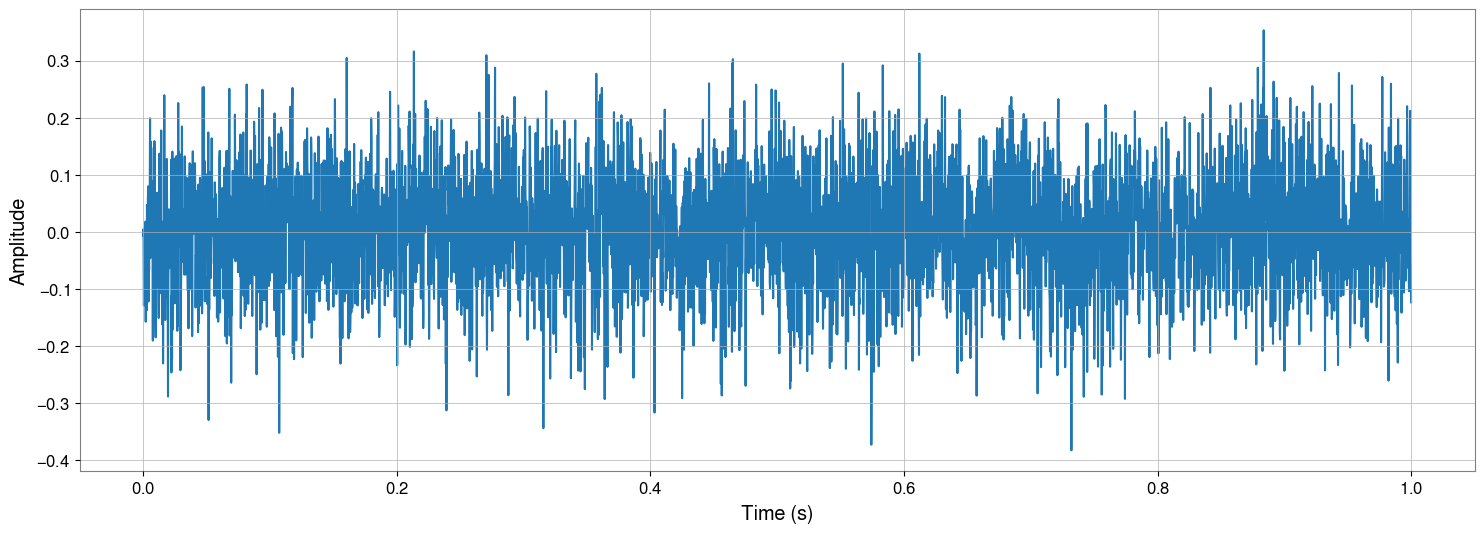

0.19972627751527766


In [37]:
fig = plt.figure(figsize=(18,6))
plt.plot(example_noise)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

print(stats.shapiro(example_noise.value).pvalue)
# warnings.filterwarnings(action='once')

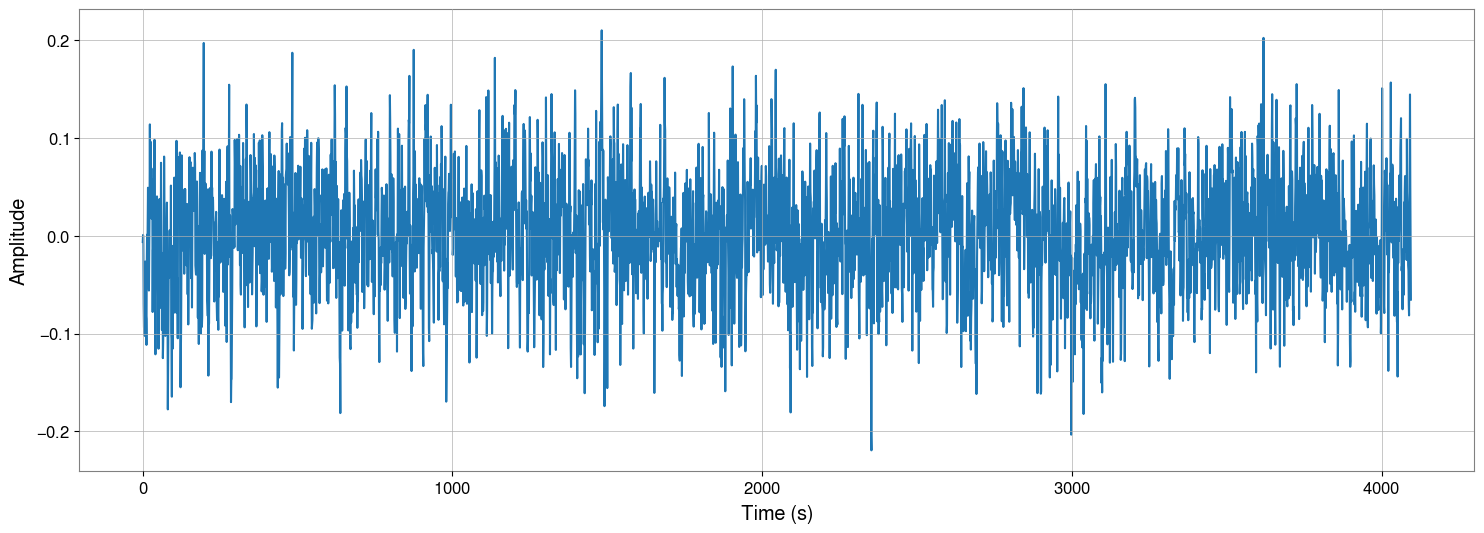

0.07676202727951639


In [38]:
fig = plt.figure(figsize=(18,6))
plt.plot(ewm_example_5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

print(stats.shapiro(ewm_example_5).pvalue)
# warnings.filterwarnings(action='once')


Applying an exponentially weighted average to our data increased the Shapiro test p-value, hence confirming my suspicion. Since exponentially weighted averages supress sudden changes in values, it makes the points seem more uniform than they probably are in reality, hence making this approach unacceptable.

However, I do want to see if this could help a bit when there is a glitch in our data. Since the EWA acts as a low-pass filter of sorts, it can attenuate most high amplitudes, while also introducing a bias. In this case, if there exists a glitch, there is a chance that it could be affected by this, putting more of an emphasis on it (p-value <0.05). 

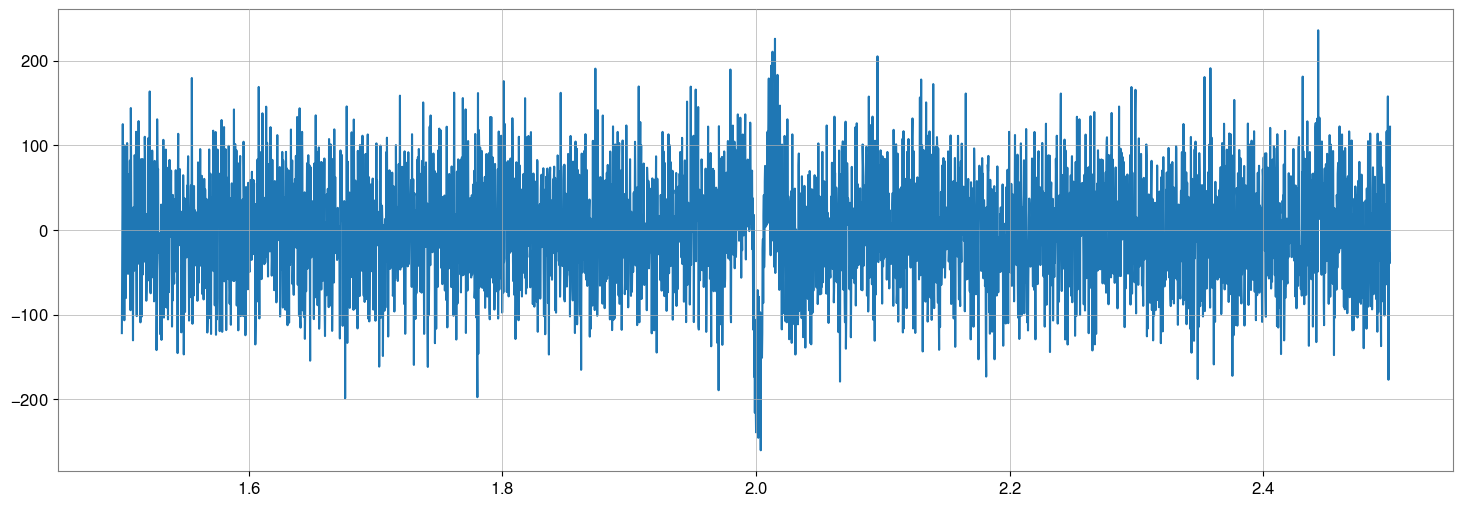

0.11571115313674346


In [39]:
fig = plt.figure(figsize=(18,6))
plt.plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['y'].iloc[0])
plt.show()

print(stats.shapiro(suspicious_glitch['y'].iloc[0]).pvalue)

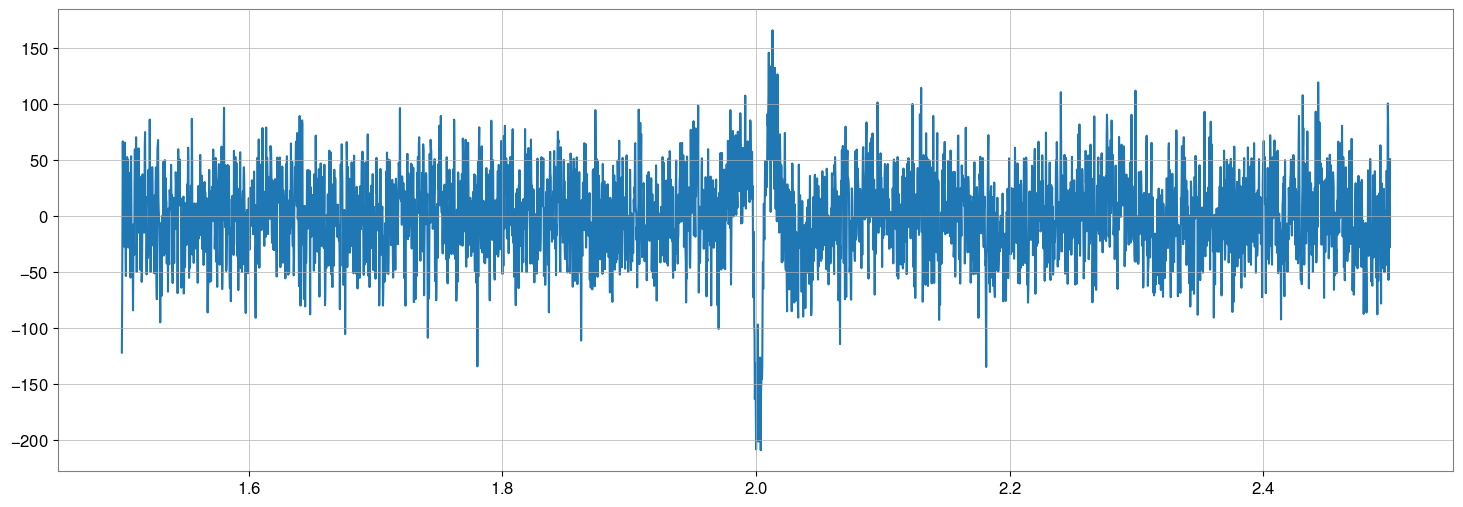

3.5425209709377325e-18


In [40]:
fig = plt.figure(figsize=(18,6))
plt.plot(suspicious_glitch['t'].iloc[0],suspicious_glitch['ewm_y'].iloc[0])
plt.show()

print(stats.shapiro(suspicious_glitch['ewm_y'].iloc[0]).pvalue)

As expected, this leads to a huge change in the p-value. I want to study this a bit more in detail for all the 50 selected points. 

In [41]:
data_df_tomte['ewm_shapiro_pvalue'] = data_df_tomte['ewm_y'].apply(lambda y: stats.shapiro(y).pvalue)

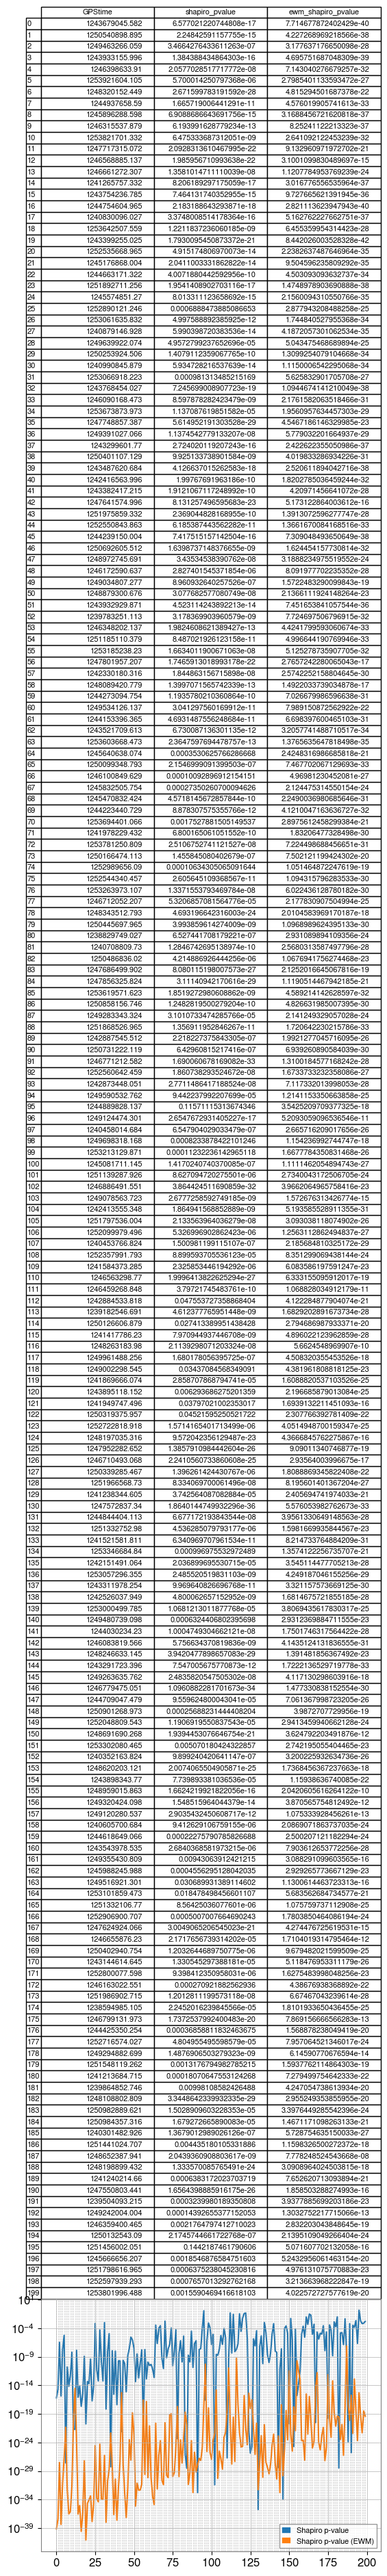

In [42]:
# fig,ax = plt.subplots(figsize=(6,10))
fig,ax = plt.subplots(dpi=100)
plt.plot(data_df_tomte['shapiro_pvalue'], label="Shapiro p-value")
plt.plot(data_df_tomte['ewm_shapiro_pvalue'], label="Shapiro p-value (EWM)")
ax.set_yscale('log')
for i in range(len(data_df_tomte)):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.table(cellText=data_df_tomte[['GPStime','shapiro_pvalue','ewm_shapiro_pvalue']].values, colLabels=['GPStime','shapiro_pvalue','ewm_shapiro_pvalue'], rowLabels=data_df_tomte.index, loc='top')
# plt.subplots_adjust(left=0.2, top=0.8)
plt.legend(fontsize=8)
plt.show()

In the above case, we can see that save for a few points, the Shapiro p-values generally have a drastic decrease when the exponentially weighted average is applied to them. This is understandable since we are aware that these samples have a glitch in them.

Below, we perform the same test with a bunch of synthetically generated white noise samples to study whether it has the same effect. The null hyopthesis I have here is that since white noise has several frequencies bounded at the same level of frequencies, the p-value will increase, i.e. all the points in our dataset will be supressed.

In [43]:
def white_noise_shapiro_values(n=50):
    np.random.seed(42)
    noise_df = pd.DataFrame(columns=['TimeSeries', 'EWM TimeSeries', 'shapiro_pvalue', 'ewm_shapiro_pvalue'])
    for i in range(n):
        white_noise = TimeSeries(np.random.normal(scale=.1, size=4096), sample_rate=4096)
        white_noise_ewm = pd.Series(white_noise.value).ewm(0.98).mean()
        noise_df.loc[len(noise_df)] = [white_noise, white_noise_ewm, stats.shapiro(white_noise.value).pvalue, stats.shapiro(white_noise_ewm).pvalue]
    return noise_df


In [44]:
white_noise_examples = white_noise_shapiro_values()

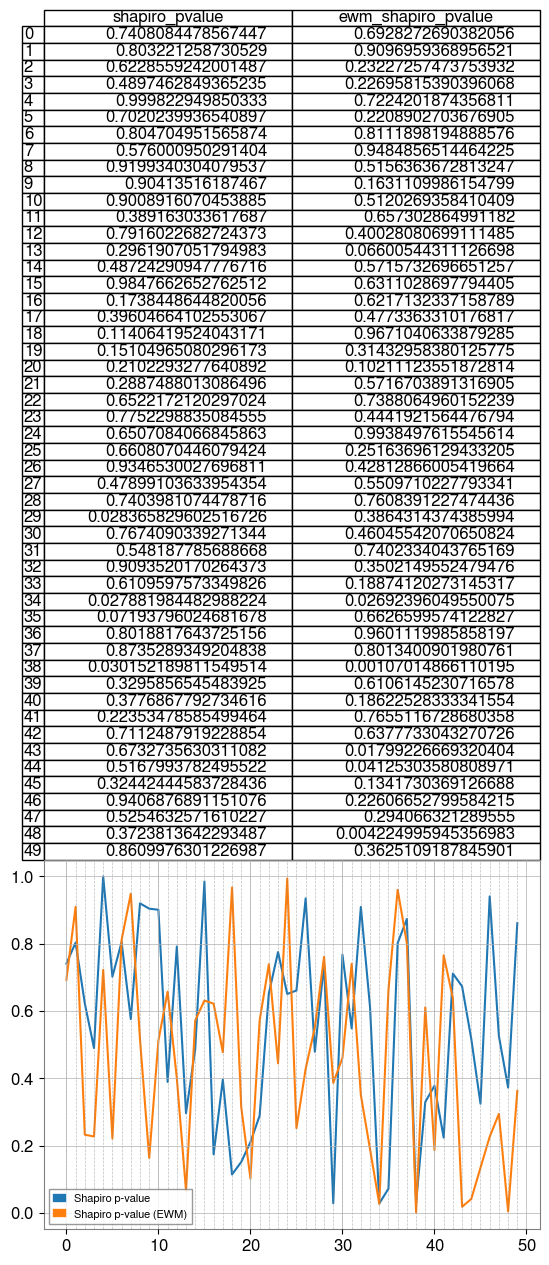

In [45]:
fig,ax = plt.subplots(dpi=100)
plt.plot(white_noise_examples['shapiro_pvalue'], label="Shapiro p-value")
plt.plot(white_noise_examples['ewm_shapiro_pvalue'], label="Shapiro p-value (EWM)")
# ax.set_yscale('log')
for i in range(len(white_noise_examples)):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.table(cellText=white_noise_examples[['shapiro_pvalue','ewm_shapiro_pvalue']].values, colLabels=['shapiro_pvalue','ewm_shapiro_pvalue'], rowLabels=white_noise_examples.index, loc='top')
# plt.subplots_adjust(left=0.2, top=0.8)
plt.legend(fontsize=8)
plt.show()

Here we see that even for gaussian noise there can be variations in the Shapiro p-value both below and above the 0.05 threshold

What can be inferred from here is that the exponentially weighted might not be a good approach.

Now I want to shift focus back onto normality testing of our dataset. First I want to start plotting Q-Q plots of the data, starting with the suspicious glitch.

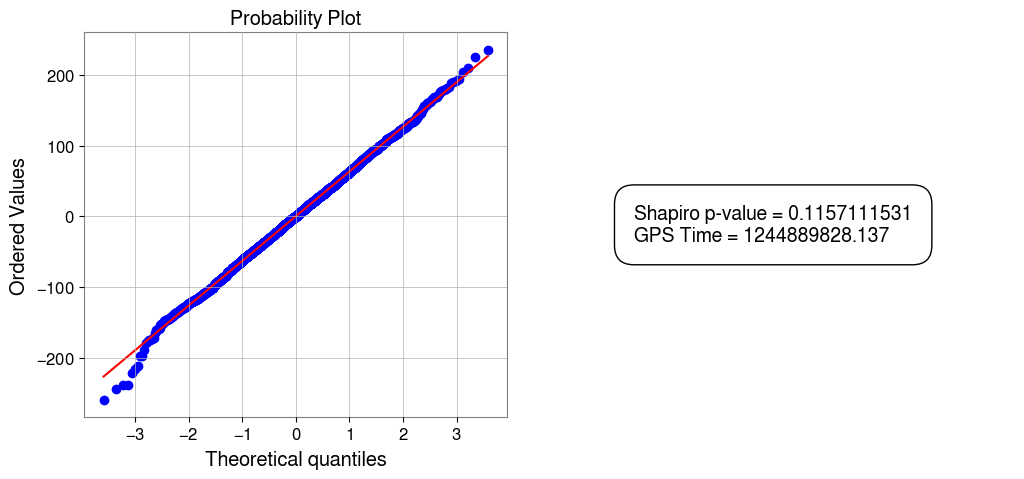

In [46]:
normality_tests.display_probability_plot(suspicious_glitch.iloc[0])

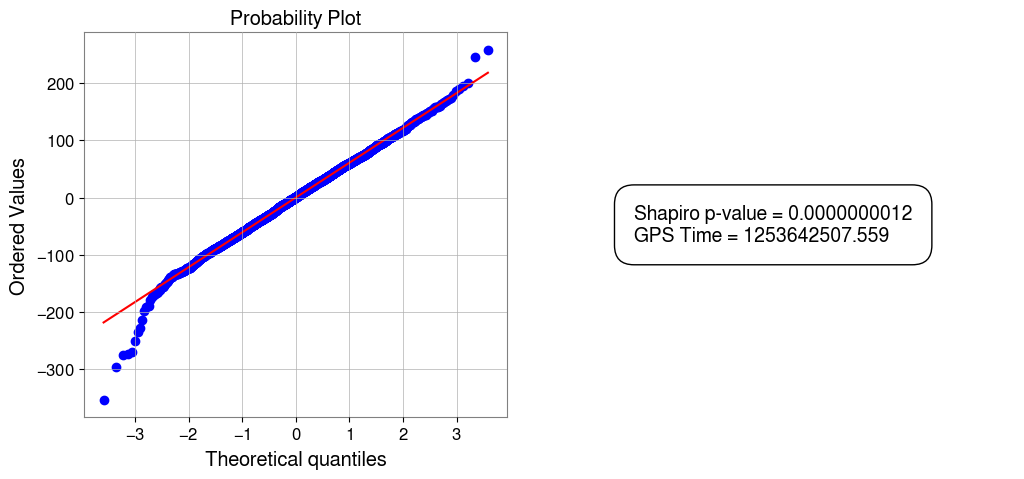

In [47]:
normality_tests.display_probability_plot(data_df_tomte.iloc[18])

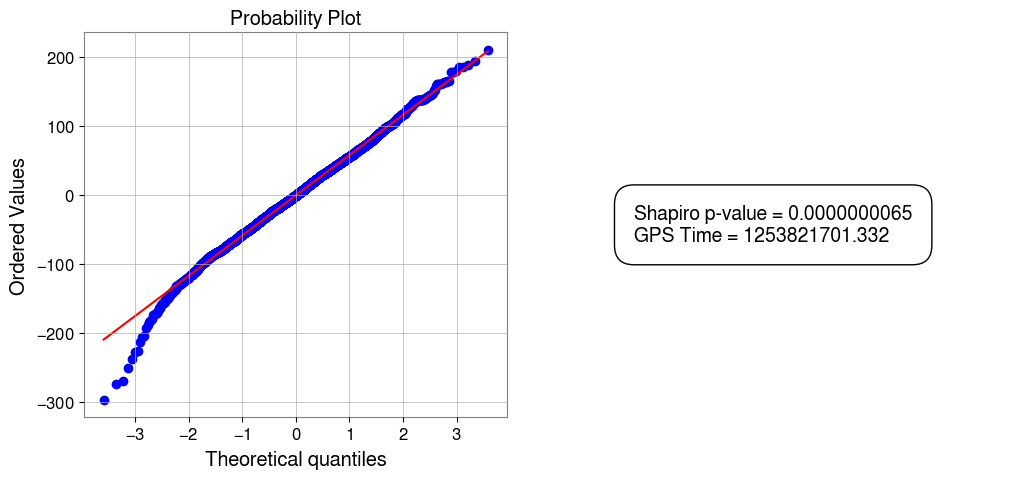

In [48]:
normality_tests.display_probability_plot(data_df_tomte.iloc[10])

In [49]:
# def display_section_qq(data, sample_rate, section_size):
#     fig, ax = plt.subplots(figsize=(10,10), dpi=100)
#     section_p_values = []
#     # print(f"Sample p-value:{data['shapiro_pvalue']}")
#     # print("Shapiro p-values")
#     # print("====================")
#     for i in range(0,sample_rate+1,section_size):
#         x = data['y'][i:i+section_size]
#         t = np.array(data['t'])[i:i+section_size]
#         if len(x) > 0:
#             if not np.isnan(stats.shapiro(x).pvalue):
#                 stats.probplot(data_df_tomte.iloc[10]["y"], dist="norm", plot=ax)
    
#     plt.plot(data['t'], data['y'])
#     plt.title(f"Shapiro Test P-values for {sample_rate//section_size} sections")
#     plt.show()

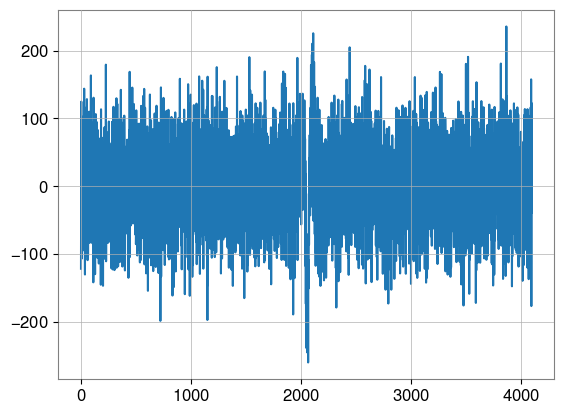

In [50]:
plt.plot(suspicious_glitch['y'].iloc[0])

Shapiro p-values
Sample p-value:0.11571115313674346
0.47817813475200444
0.20430768745215871
0.3031710170172552
0.8425765720379519
0.9477233285161484
0.588056741760203
0.07895340248447287
0.9719397699014631
0.6464251308987009
0.9701737138940848
0.0005044773618506759
0.5479363552829939
0.699799797334549
0.501931328853032
0.2478137103425585
0.9128554673466049
0.7553162873143683
0.5444213452676305
0.9036071243318973
0.5773546852041724
0.16849015045497506


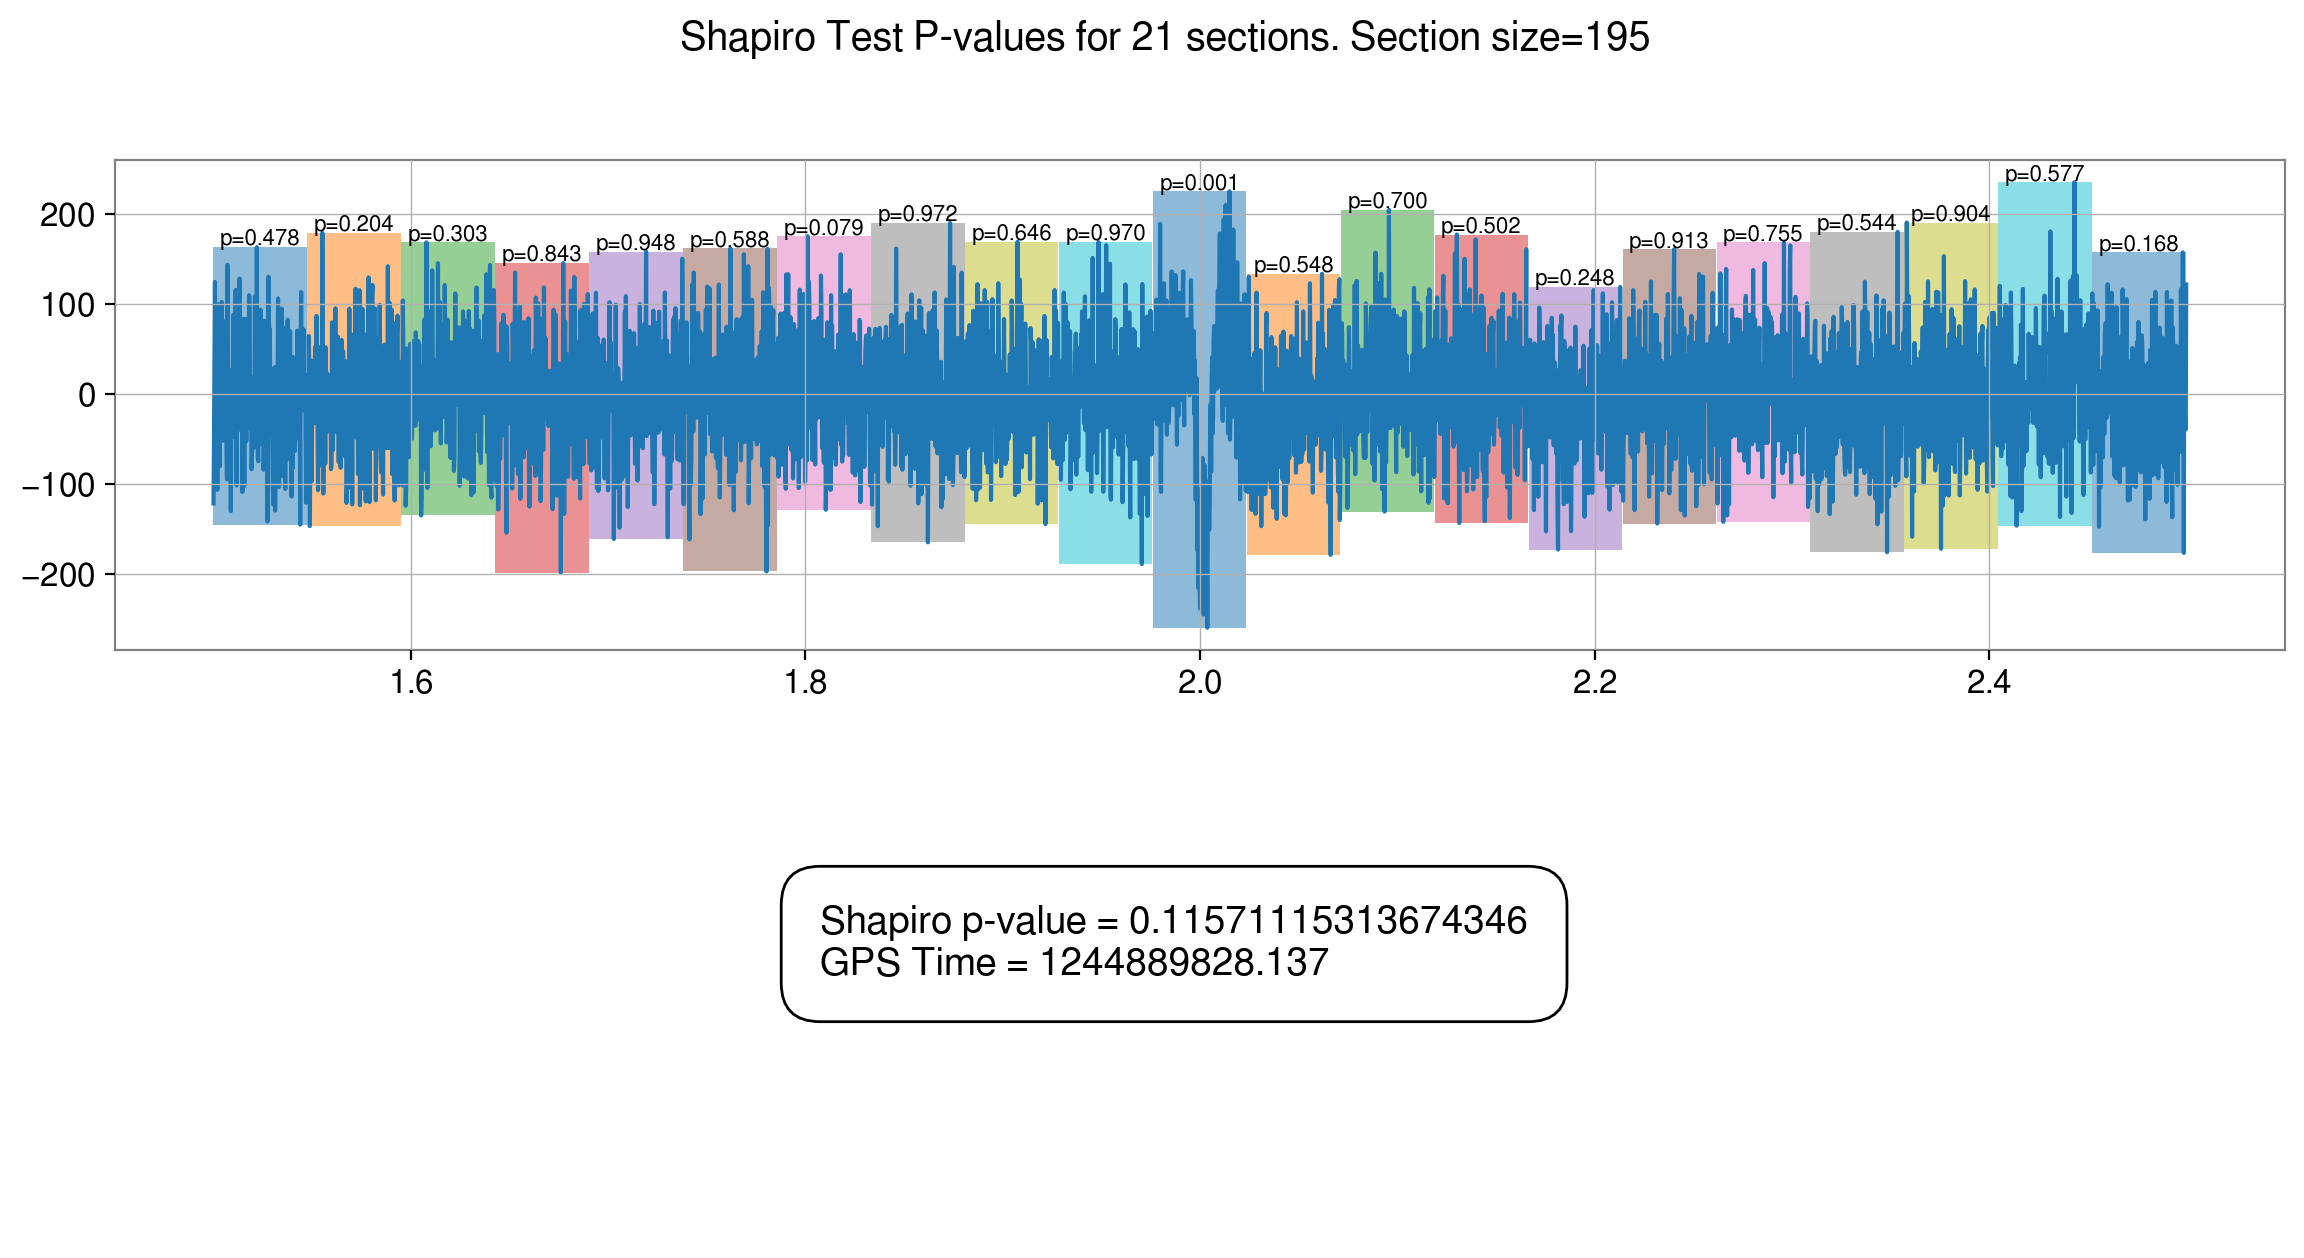

In [51]:
section_list = normality_tests.display_section_shapiro(suspicious_glitch.iloc[0], 21)

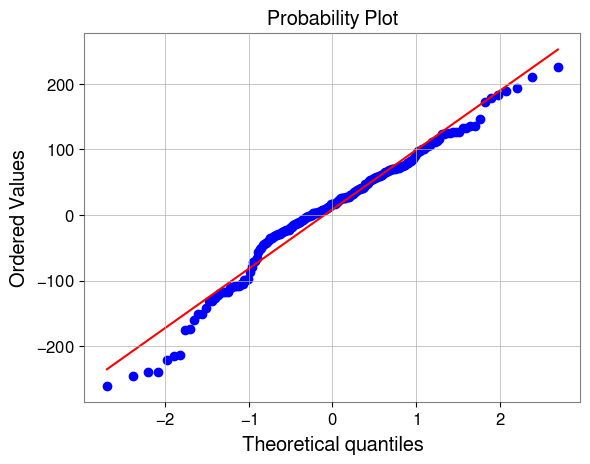

In [52]:
fig,ax = plt.subplots()
stats.probplot(section_list[10], dist="norm", plot=ax)
plt.show()

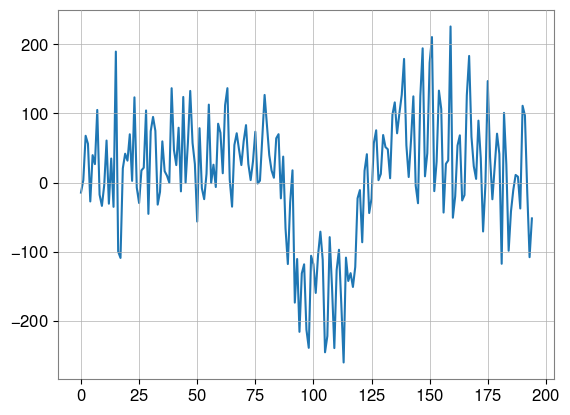

In [53]:
plt.plot(section_list[10])

Shapiro p-values
Sample p-value:4.9572799237652696e-05
0.10005450876350015
3.990955288386076e-05
0.7306184106028834


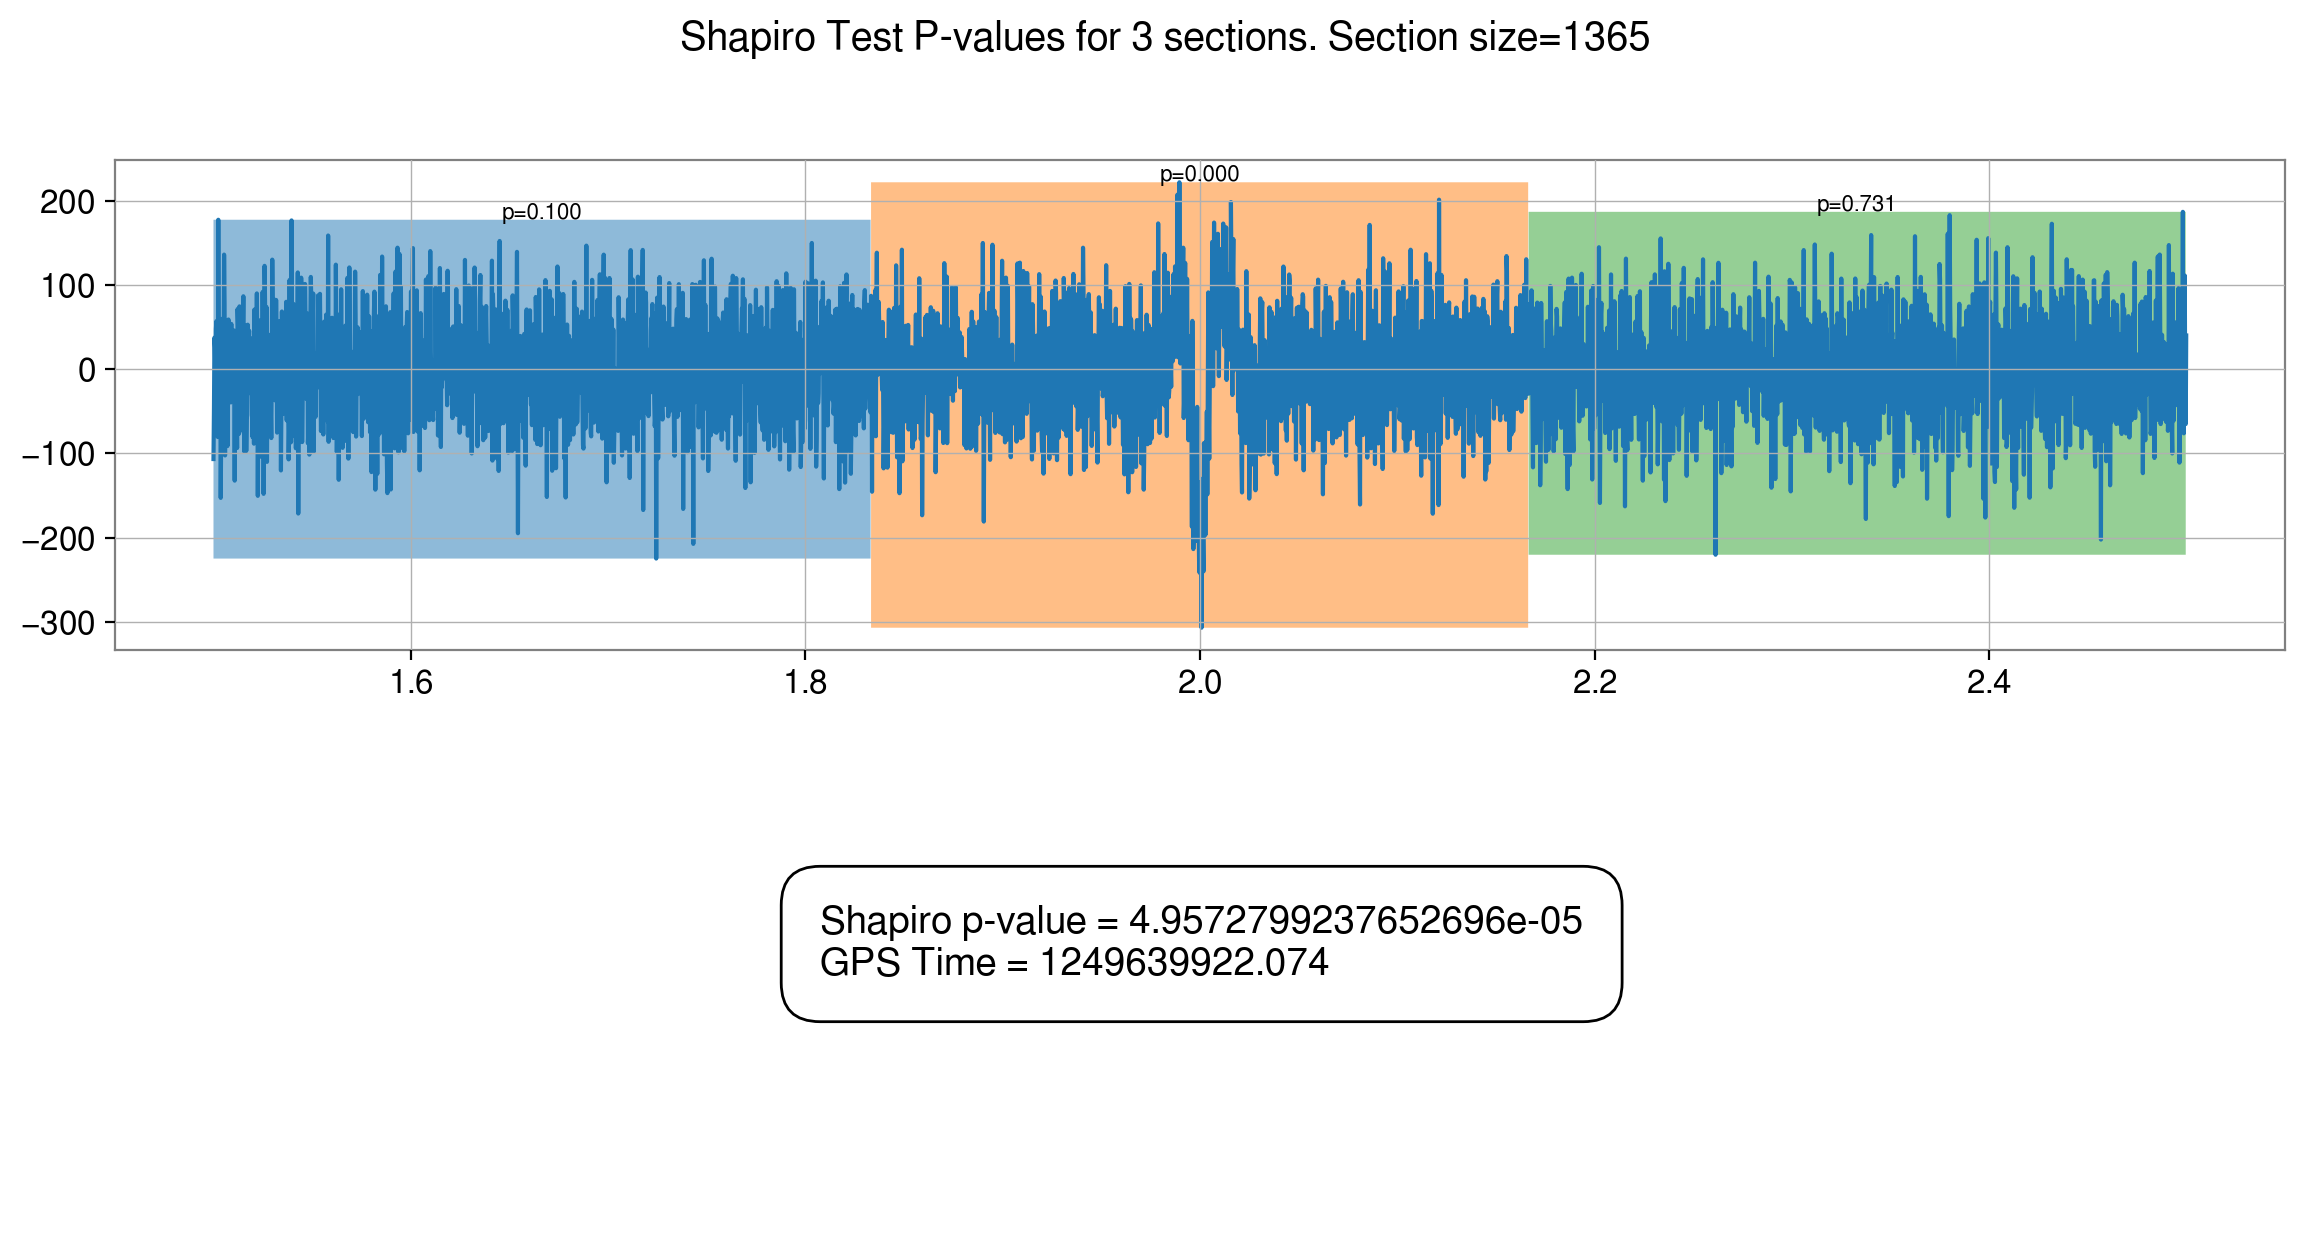

In [54]:
_ = normality_tests.display_section_shapiro(data_df_tomte.iloc[28], 3)

Shapiro p-values
Sample p-value:4.9572799237652696e-05
0.4813842275442518
0.7906982631206123
0.007212948607388694
0.46848394445501357
9.224412303840812e-05
0.9532720844510856
0.5975506429914226
0.935519377066306
0.6164782196294774


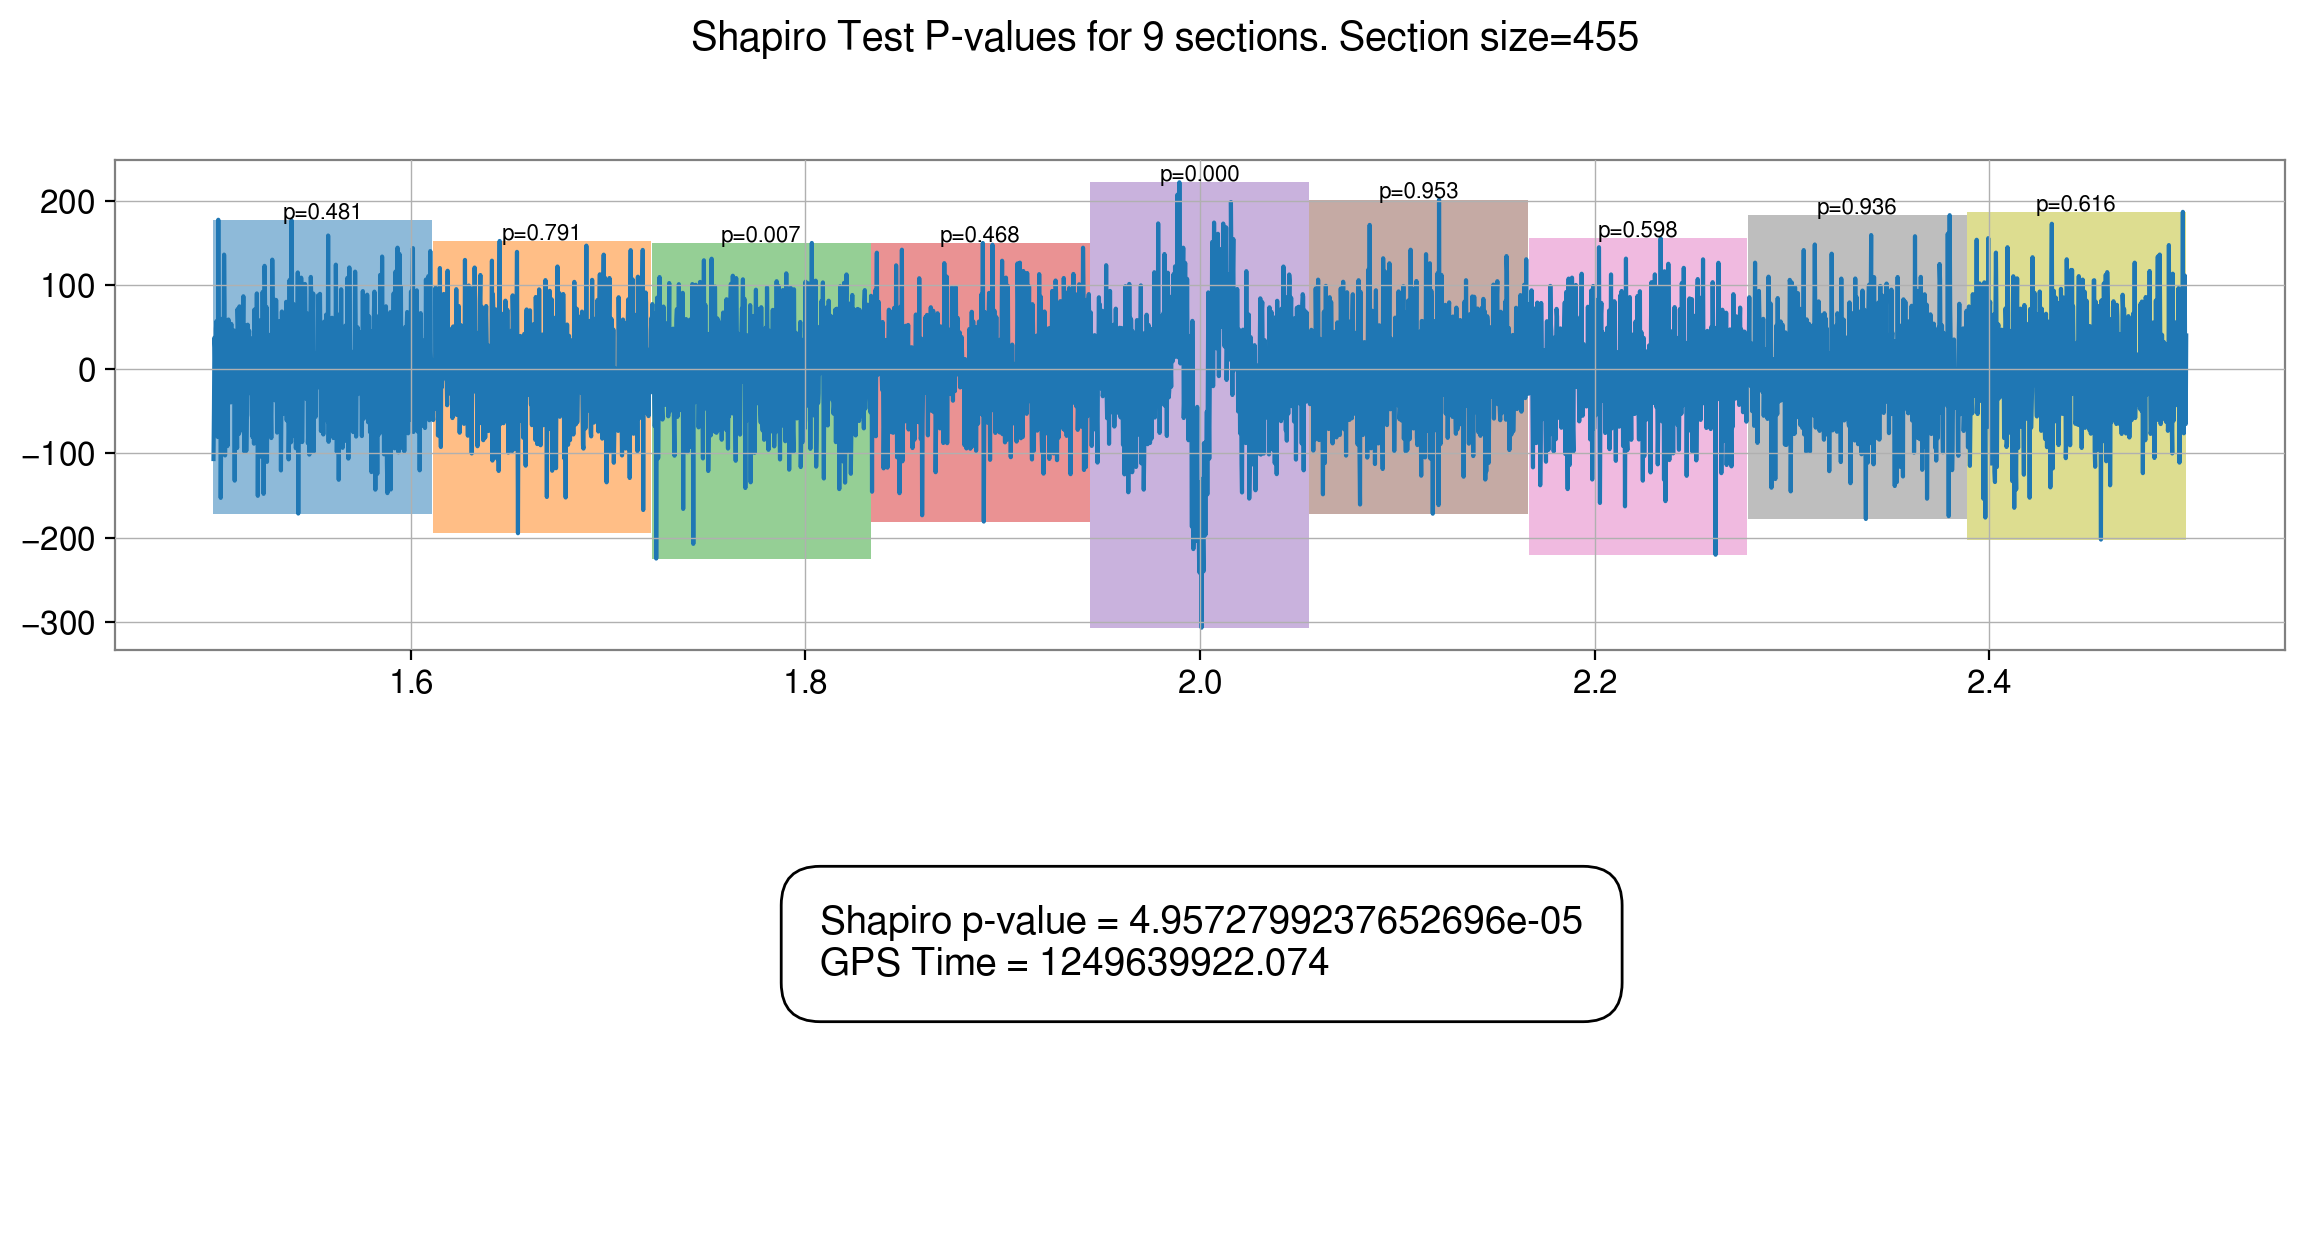

In [55]:
_ = normality_tests.display_section_shapiro(data_df_tomte.iloc[28], 9)

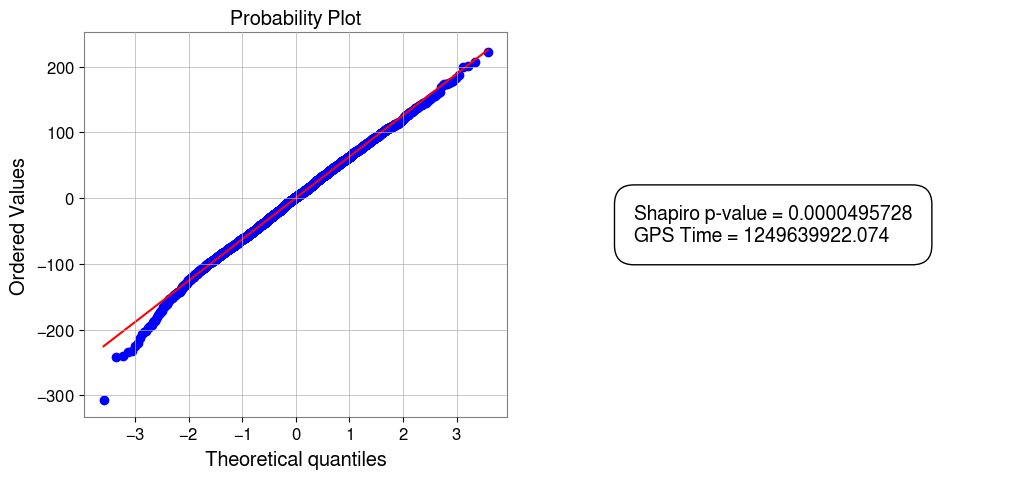

In [56]:
normality_tests.display_probability_plot(data_df_tomte.iloc[28])

Shapiro p-values
Sample p-value:4.9572799237652696e-05
0.5968225203452786
0.1848411047629933
0.10481025596540644
0.8999900199203842
0.10731301574040786
0.11574723094386852
0.18416652998590038
0.8435938244901853
0.36559203430099624
0.33118424793358925
0.00016009210443194115
0.18124370087184394
0.6152196001143843
0.8992030724079823
0.4091948199084093
0.2622330484750329
0.6106103897141183
0.9630967990078102
0.7302295365105322
0.8897633386269137
0.188083843565725


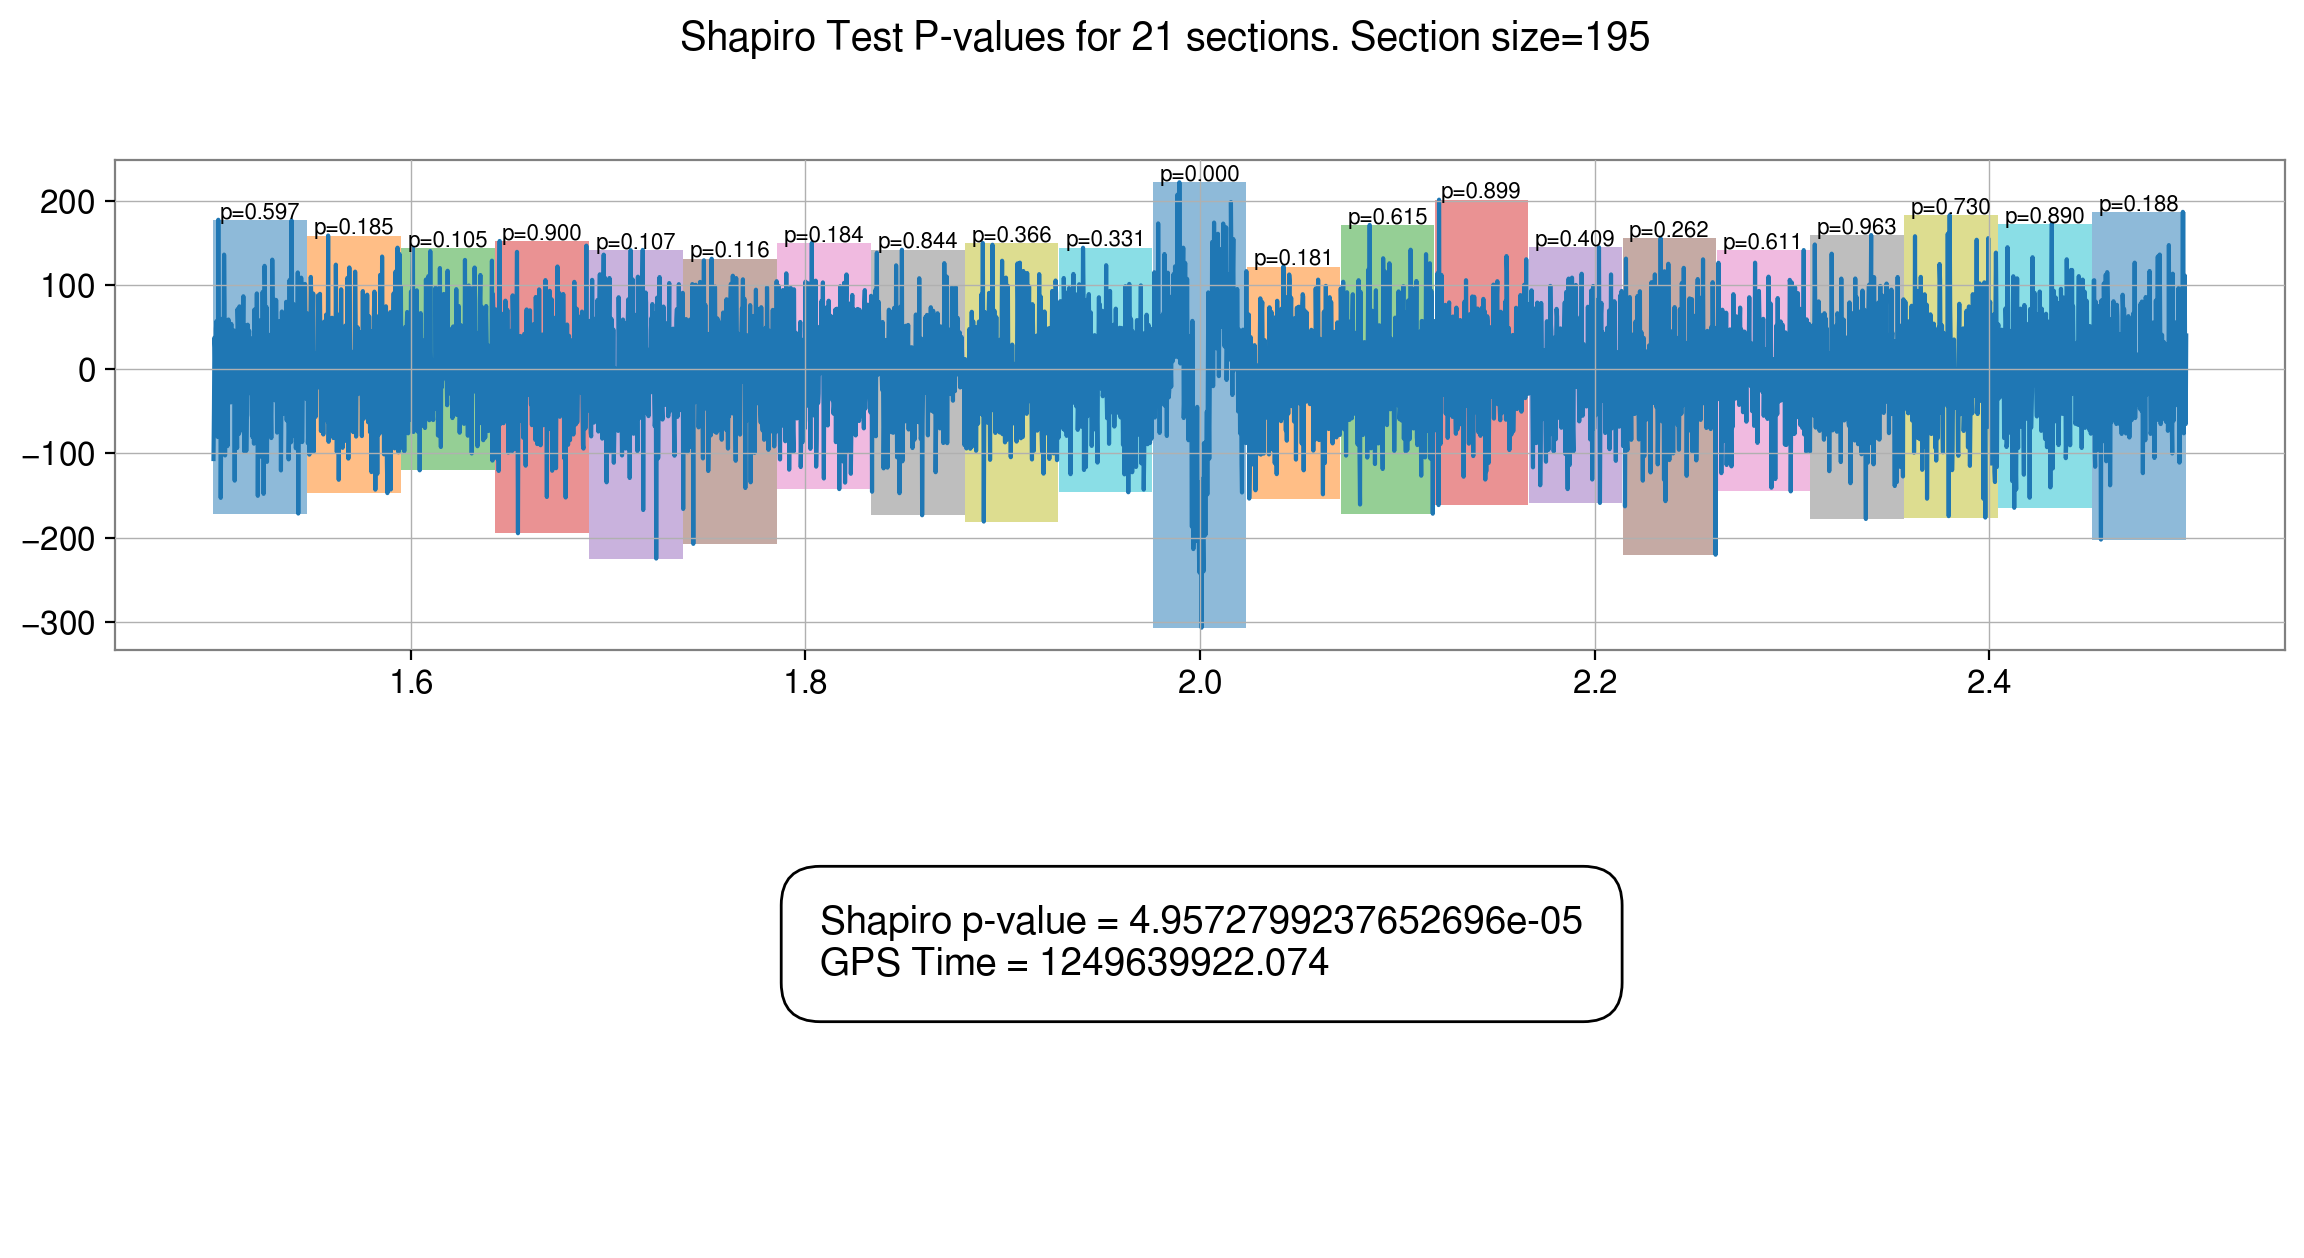

In [57]:
_ = normality_tests.display_section_shapiro(data_df_tomte.iloc[28], 21)

Shapiro p-values
Sample p-value:1.2211837236060185e-09
0.553136490274567
0.8533891705686119
0.44860763599242337
0.2495073058689749
2.0541030160652058e-07
0.35000822526312314
0.4622097147606536
0.5649899470537856
0.289432561285377


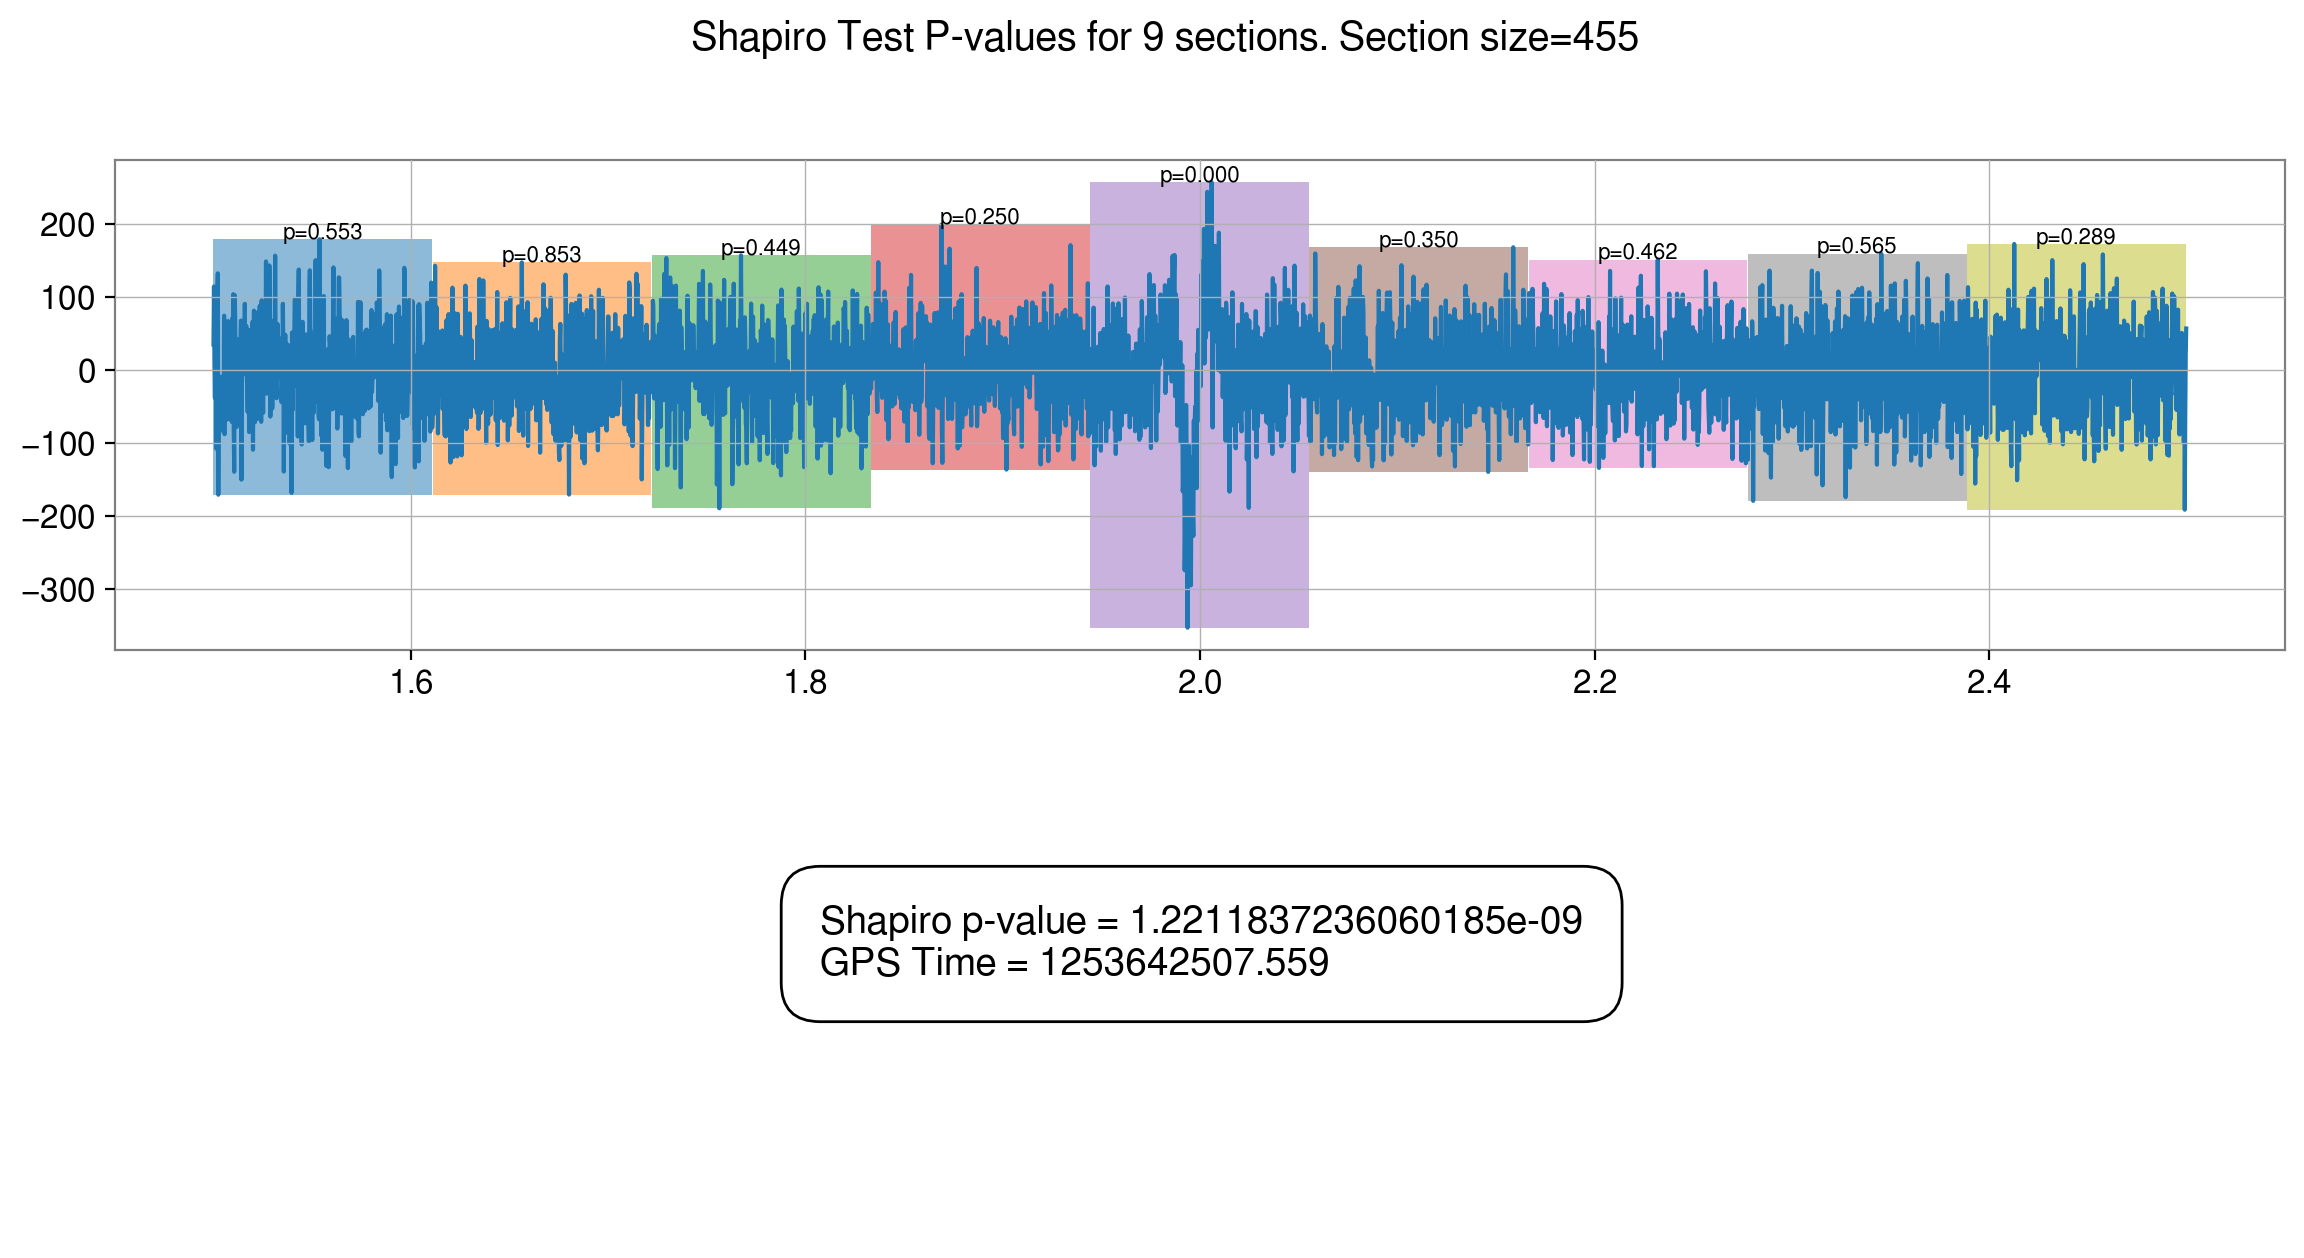

In [58]:
_ = normality_tests.display_section_shapiro(data_df_tomte.iloc[18], 9)

Up to this point I have tested the gitch with a few statistical tests of normality, mainly focusing on the Shapiro-Wilks test. The initial assumption was that the SW test worked well in identifying the 1 second glitch sample to be non-gaussian due to the low p-values. However, on checking the Q-Q plot of the samples against normal distributions, it is found that the samples are actually more akin to gaussian distributions. On testing with smaller chunks of the signal, the Shapiro-Wilks test is able to consistently identify gaussian and non-gaussian sections of the signal.

Hence we see that the test seems to work relatively well when the number of data points per sample is low, however, when we approach a large number of points, say close to 5000, the test fails since the signal represents white noise, giving us a false negatives (Our whitened glitch being identified as gaussian) for a huge portion of our data.

A good use case for what we have experimented with till now could be using the Shapiro on the subsection around our glitch (around 0.25 seconds)

I now want a function which can allow us to study the sample signal using the Shapiro-Wilks, Kolmogorov-Smirnov and Anderson-Darling tests, while also allowing the isolation of the glitched portions of the data for a better understanding of its gaussuanity. I will also be looking at the skewness and kurtosis of our samples to check by how much each sample differs from a normal distribution.

Anderson Statistics
Section 1: 
AD Statistic= 0.5584263124903828
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 2: 
AD Statistic= 0.35129544066546714
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 3: 
AD Statistic= 0.5640058917371107
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 4: 
AD Statistic= 0.23675723371616186
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 5: 
AD Statistic= 1.2157608574266305
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 6: 
AD Statistic= 0.41005570329411967
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 7: 
AD Statistic= 0.47157567162412306
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 8: 
AD Statistic= 0.2573061613090317
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 9: 
AD Statistic= 0.37523736742048186
Critical Values=[0.571 0.65  0.78  0.91  1.083]


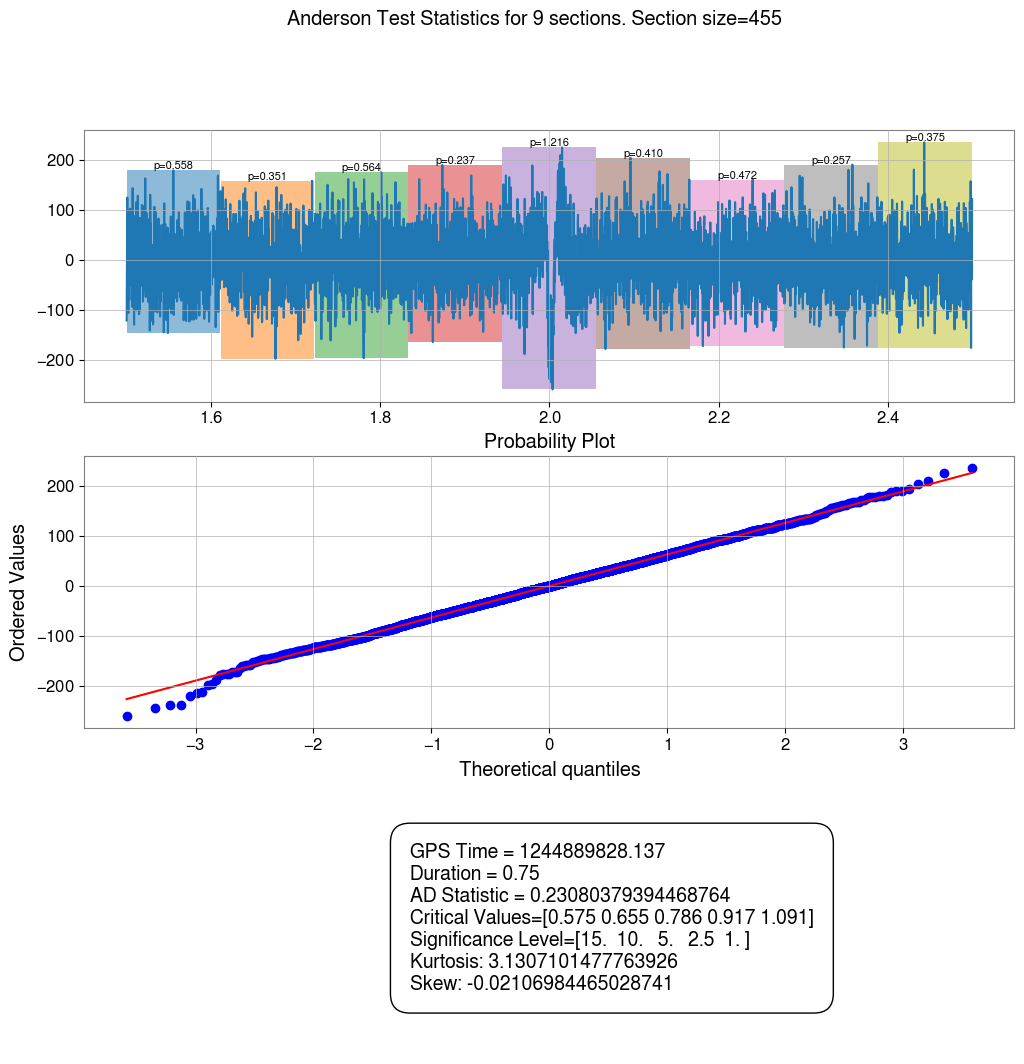

In [59]:
_ = normality_tests.section_statistics(suspicious_glitch.iloc[0],stat_test="Anderson", sections=9)

Anderson Statistics
Section 1: 
AD Statistic= 0.4108013621583382
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 2: 
AD Statistic= 0.17854622196648506
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 3: 
AD Statistic= 0.7448397015066348
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 4: 
AD Statistic= 0.34185060043660087
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 5: 
AD Statistic= 1.8540896630527754
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 6: 
AD Statistic= 0.19708859547682778
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 7: 
AD Statistic= 0.24648530375196742
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 8: 
AD Statistic= 0.23021769555850824
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 9: 
AD Statistic= 0.5567877301463113
Critical Values=[0.571 0.65  0.78  0.91  1.083]


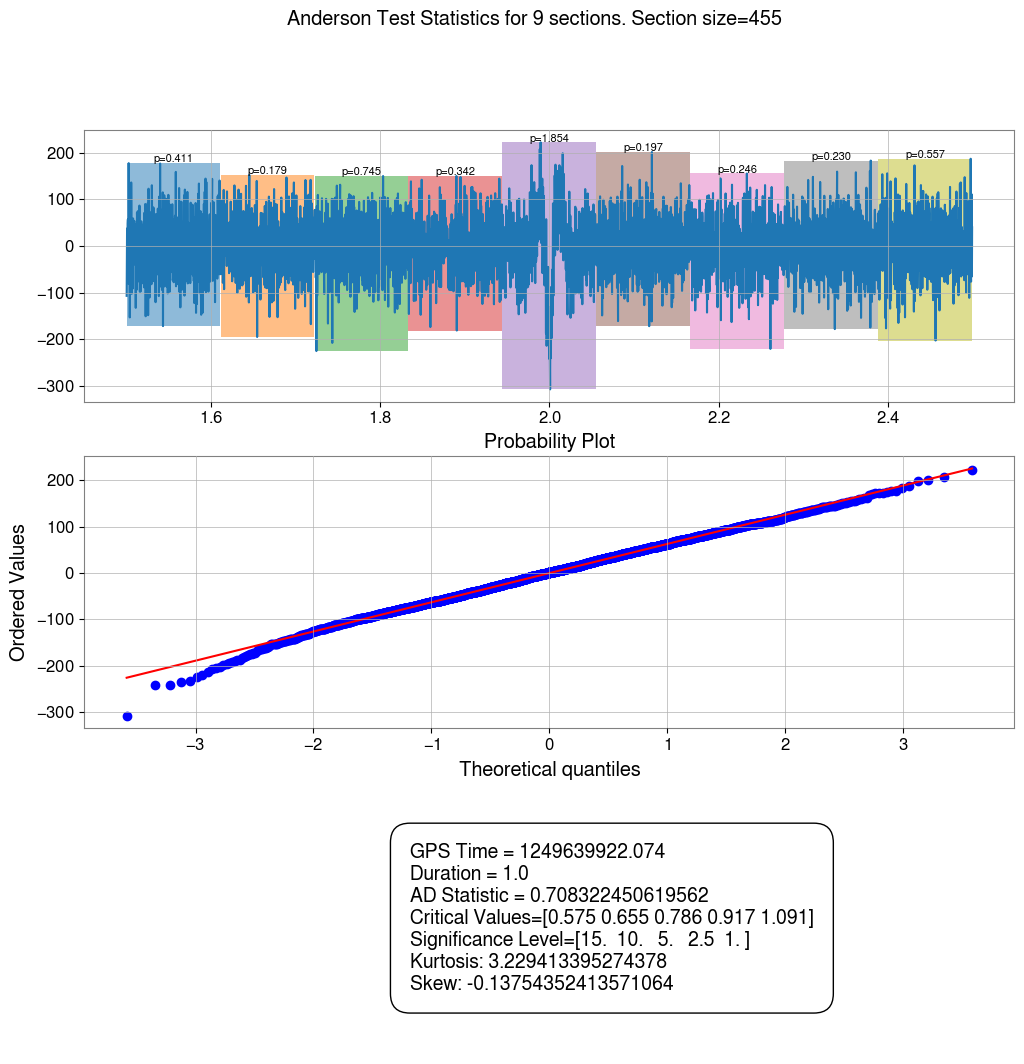

In [60]:
_ = normality_tests.section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", sections=9)


Anderson Statistics
Section 1: 
AD Statistic= 0.4221275351846714
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 2: 
AD Statistic= 0.5112584955452348
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 3: 
AD Statistic= 0.5033590349191286
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 4: 
AD Statistic= 0.21769329426683726
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 5: 
AD Statistic= 0.5235972616958406
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 6: 
AD Statistic= 0.584771417850618
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 7: 
AD Statistic= 0.5488812976953454
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 8: 
AD Statistic= 0.24455958147717638
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 9: 
AD Statistic= 0.3921219375584428
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 10: 
AD Statistic= 0.3634833783400495
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 11: 
AD Statistic= 2.079158784685376
Cri

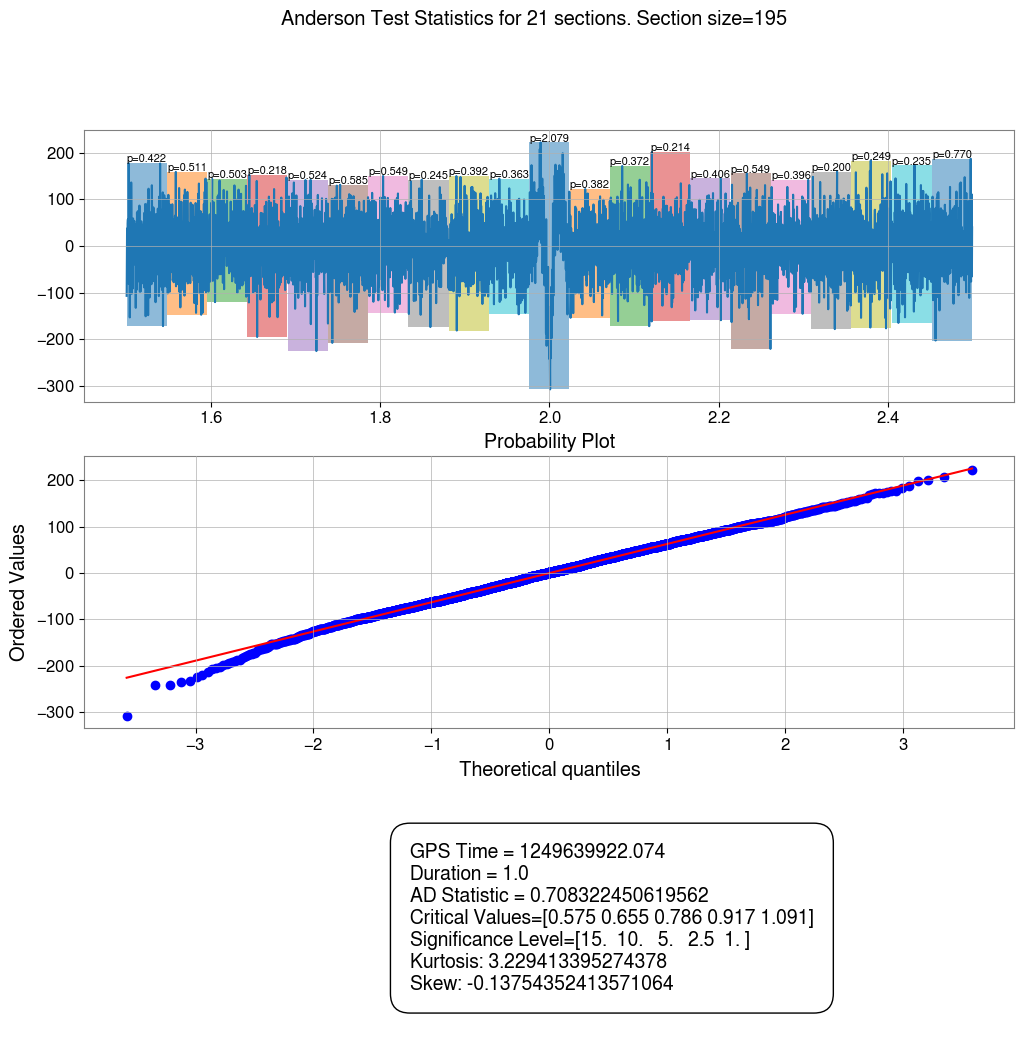

In [61]:
_ = normality_tests.section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", sections=21)

Anderson Statistics
Section 1: 
AD Statistic= 0.4221275351846714
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 2: 
AD Statistic= 0.5112584955452348
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 3: 
AD Statistic= 0.5033590349191286
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 4: 
AD Statistic= 0.21769329426683726
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 5: 
AD Statistic= 0.5235972616958406
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 6: 
AD Statistic= 0.584771417850618
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 7: 
AD Statistic= 0.5488812976953454
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 8: 
AD Statistic= 0.24455958147717638
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 9: 
AD Statistic= 0.3921219375584428
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 10: 
AD Statistic= 0.3634833783400495
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 11: 
AD Statistic= 2.079158784685376
Cri

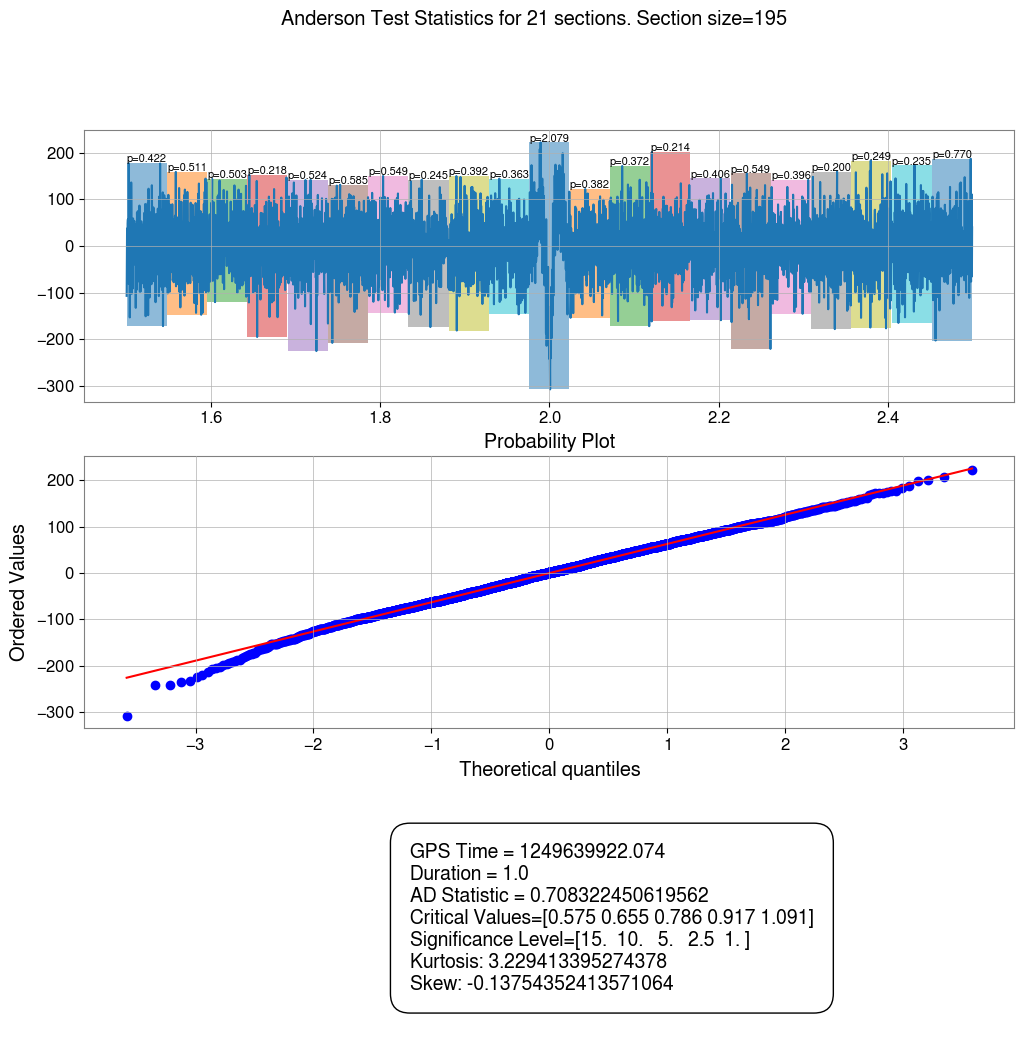

In [62]:
_ = normality_tests.section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", sections=21)

KS Statistics
1.3985298386311929e-99
2.8496422200430707e-102
3.5678126786188427e-110
1.0449751297649109e-100
3.912931720111595e-116
1.2265730913479168e-93
2.335448144074746e-98
2.2992041988914298e-94
8.607979071756265e-99
0.0


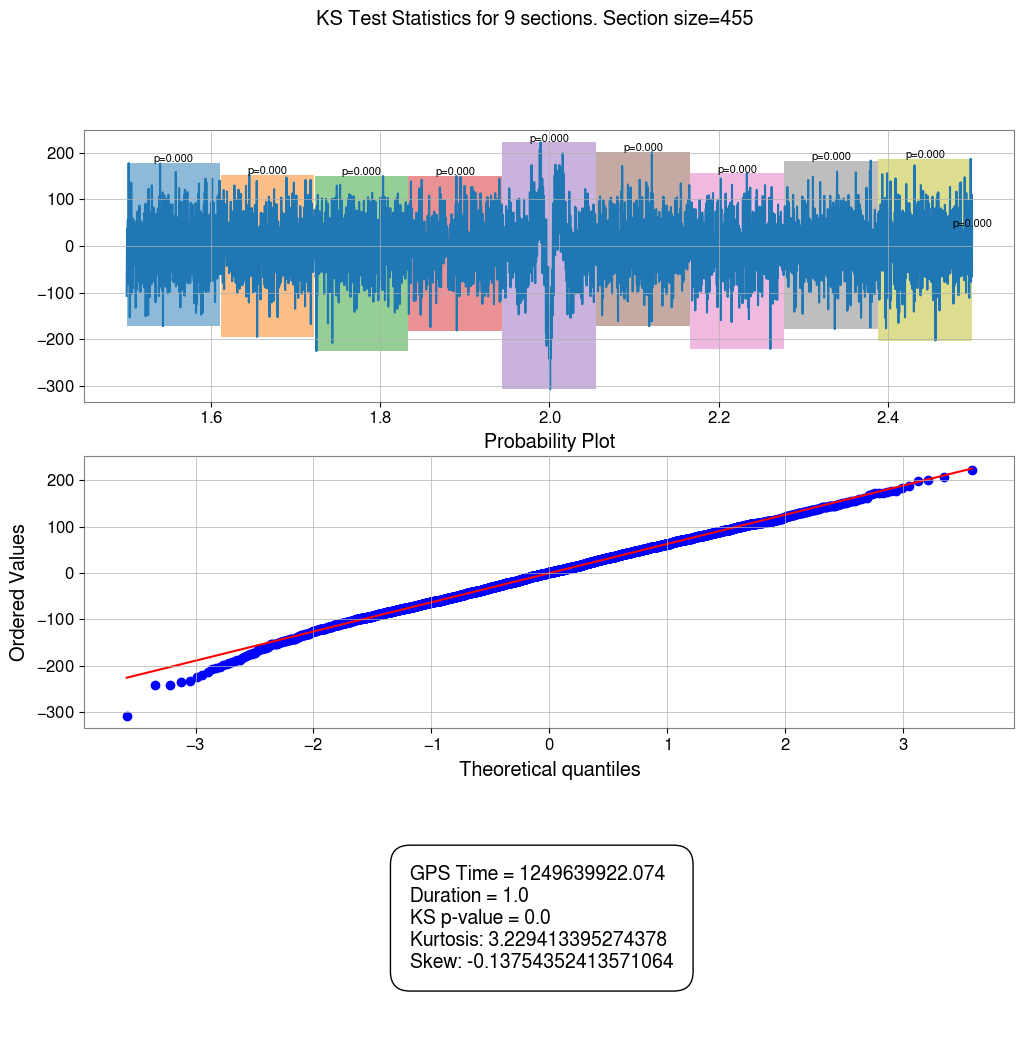

In [63]:
_ = normality_tests.section_statistics(data_df_tomte.iloc[28],stat_test="KS", sections=9)

This glitch, for some reason, fails most of the tests. I want to study it a bit.

[This](https://stats.stackexchange.com/questions/20793/what-is-gaussianity-and-how-do-you-perform-gaussianity-testing-in-macroeconom) stackexchange post goes a bit into testing gaussianity for time series information that could be useful. It, however criticizes the approach of using elliptically symmetric distributions (normal distributions) as a way to test gaussianity of a timeseries.

In [64]:
# pd.options.display.float_format = '{:.10f}'.format
data_df_tomte[[
    'GPStime',
    'duration',
    'shapiro_pvalue',
    'ks_pvalue',
    'ad_statistic',
    'ad_critical_values',
    'ad_significance_level',
    'kurtosis',
    'skew',
    ]].head()

GPStime  duration  shapiro_pvalue  ks_pvalue  ad_statistic  \
0  1.243679e+09     1.250    6.577021e-17        0.0      2.311046   
1  1.250541e+09     1.500    2.248426e-15        0.0      2.019245   
2  1.249463e+09     1.500    3.466428e-07        0.0      2.179921   
3  1.243933e+09     1.160    1.384388e-16        0.0      1.855129   
4  1.246399e+09     0.875    2.057703e-08        0.0      0.483149   

                    ad_critical_values        ad_significance_level  kurtosis  \
0  [0.575, 0.655, 0.786, 0.917, 1.091]  [15.0, 10.0, 5.0, 2.5, 1.0]  4.383921   
1  [0.575, 0.655, 0.786, 0.917, 1.091]  [15.0, 10.0, 5.0, 2.5, 1.0]  4.297434   
2  [0.575, 0.655, 0.786, 0.917, 1.091]  [15.0, 10.0, 5.0, 2.5, 1.0]  2.959606   
3  [0.575, 0.655, 0.786, 0.917, 1.091]  [15.0, 10.0, 5.0, 2.5, 1.0]  4.223643   
4  [0.575, 0.655, 0.786, 0.917, 1.091]  [15.0, 10.0, 5.0, 2.5, 1.0]  3.436893   

       skew  
0 -0.248636  
1 -0.201071  
2 -0.088674  
3 -0.283612  
4 -0.134649

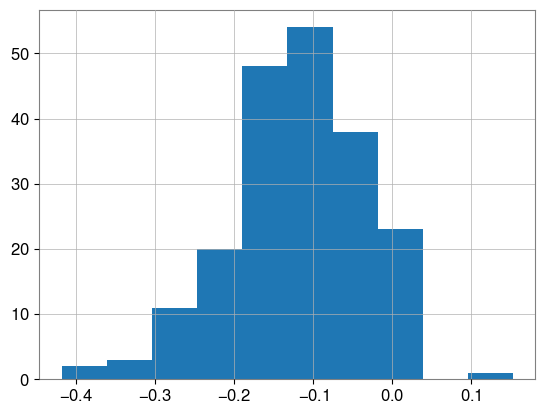

In [67]:
plt.hist(data_df_tomte['skew'])
plt.show()

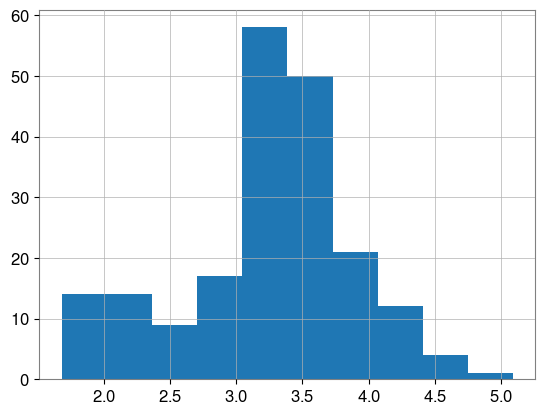

In [68]:
plt.hist(data_df_tomte['kurtosis'])
plt.show()